# ⚽ Fantasy Premier League Performance Prediction (Milestone 1)
### Team 14 – German University in Cairo  
**Course:** Media Engineering & Technology – Dr. Nourhan Ehab  

---

## 🧭 Overview
This notebook presents a **complete end-to-end machine learning pipeline** to predict *upcoming Fantasy Premier League (FPL) points* for Premier League players.

Millions of managers worldwide rely on statistical insight for better fantasy decisions.  
We use **real-world football data** to forecast player performance, applying **data cleaning**, **feature engineering**, **predictive modeling**, and **explainable AI (XAI)**.

### 🎯 Objectives
1. Clean and preprocess multi-season FPL data.  
2. Engineer a *form* feature representing recent player momentum.  
3. Answer analytical questions about position-wise and player-level performance.  
4. Build two predictive models (Random Forest + Feedforward Neural Network).  
5. Compare performance using MAE, MSE, RMSE, and R².  
6. Explain predictions using **SHAP** and **LIME**.  
7. Provide a reusable **inference function** to predict future player points.

---

## 📊 Dataset
**Source:** [Kaggle – Fantasy Football Dataset](https://www.kaggle.com/datasets/joebeachcapital/fantasy-football?select=cleaned_merged_seasons.csv)  
**Granularity:** Player-gameweek level (each row = one player’s match performance).  
**Target:** `upcoming_total_points` → the total points a player will earn *next* gameweek.  

We removed popularity-based columns (like `selected_by_percent`) to keep the analysis purely performance-driven.

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import shap
import lime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-10-24 20:46:28.845144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761338789.027432      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761338789.080703      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/fantasy-football/cleaned_merged_seasons.csv")
teams = pd.read_csv("/kaggle/input/fantasy-football/master_team_list.csv")

df.head(), teams.head()

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


(  season_x                name position team_x  assists  bonus  bps  \
 0  2016-17     Aaron Cresswell      DEF    NaN        0      0    0   
 1  2016-17        Aaron Lennon      MID    NaN        0      0    6   
 2  2016-17        Aaron Ramsey      MID    NaN        0      0    5   
 3  2016-17  Abdoulaye Doucouré      MID    NaN        0      0    0   
 4  2016-17        Adam Forshaw      MID    NaN        0      0    3   
 
    clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
 0             0         0.0      454  ...           2.0     0.0             0   
 1             0         0.3      142  ...           1.0     0.0             1   
 2             0         4.9       16  ...           3.0    23.0             2   
 3             0         0.0      482  ...           1.0     0.0             0   
 4             0         1.3      286  ...           1.0     0.0             1   
 
    transfers_balance  transfers_in transfers_out  value  was_home  \
 0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [4]:
df.describe()

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
count,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,...,96169.000000,96169.000000,96169.000000,96169.000000,9.616900e+04,9.616900e+04,9.616900e+04,96169.000000,96169.000000,96169.000000
mean,0.041042,0.108715,6.080275,0.106739,4.734000,327.063264,198.413824,0.495887,0.045514,1.715793,...,1.265158,1.516393,5.287598,1.379270,1.677100e+03,1.454716e+04,1.286945e+04,51.352390,0.053167,20.772099
std,0.215378,0.492334,9.850595,0.308783,10.689879,194.313766,108.884200,0.974269,0.233644,3.042551,...,1.229086,1.349184,13.368420,2.542535,6.581628e+04,5.725343e+04,4.840128e+04,12.667432,0.224367,10.941742
min,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-7.000000,-2.180978e+06,0.000000e+00,0.000000e+00,37.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,105.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,-1.374000e+03,4.600000e+01,1.280000e+02,44.000000,0.000000,11.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,203.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-5.800000e+01,4.380000e+02,1.104000e+03,48.000000,0.000000,22.000000
75%,0.000000,0.000000,10.000000,0.000000,2.400000,486.000000,293.000000,1.000000,0.000000,2.500000,...,2.000000,2.000000,2.000000,2.000000,7.900000e+01,5.042000e+03,7.562000e+03,54.000000,0.000000,30.000000
max,4.000000,3.000000,128.000000,1.000000,170.900000,778.000000,380.000000,9.000000,4.000000,32.800000,...,7.000000,9.000000,186.000000,29.000000,1.983733e+06,2.104464e+06,2.233619e+06,133.000000,1.000000,38.000000


In [5]:
original_data = df.shape
print(f"Original dataset shape: {original_data}")

Original dataset shape: (96169, 37)


In [6]:
print("Missing values in main dataset:")
null_counts = df.isnull().sum() 
print(null_counts[null_counts > 0])
print("\nPercentage of null values:")
print((null_counts[null_counts > 0] / len(df) * 100).round(2))

Missing values in main dataset:
team_x    19852
dtype: int64

Percentage of null values:
team_x    20.64
dtype: float64


<Axes: >

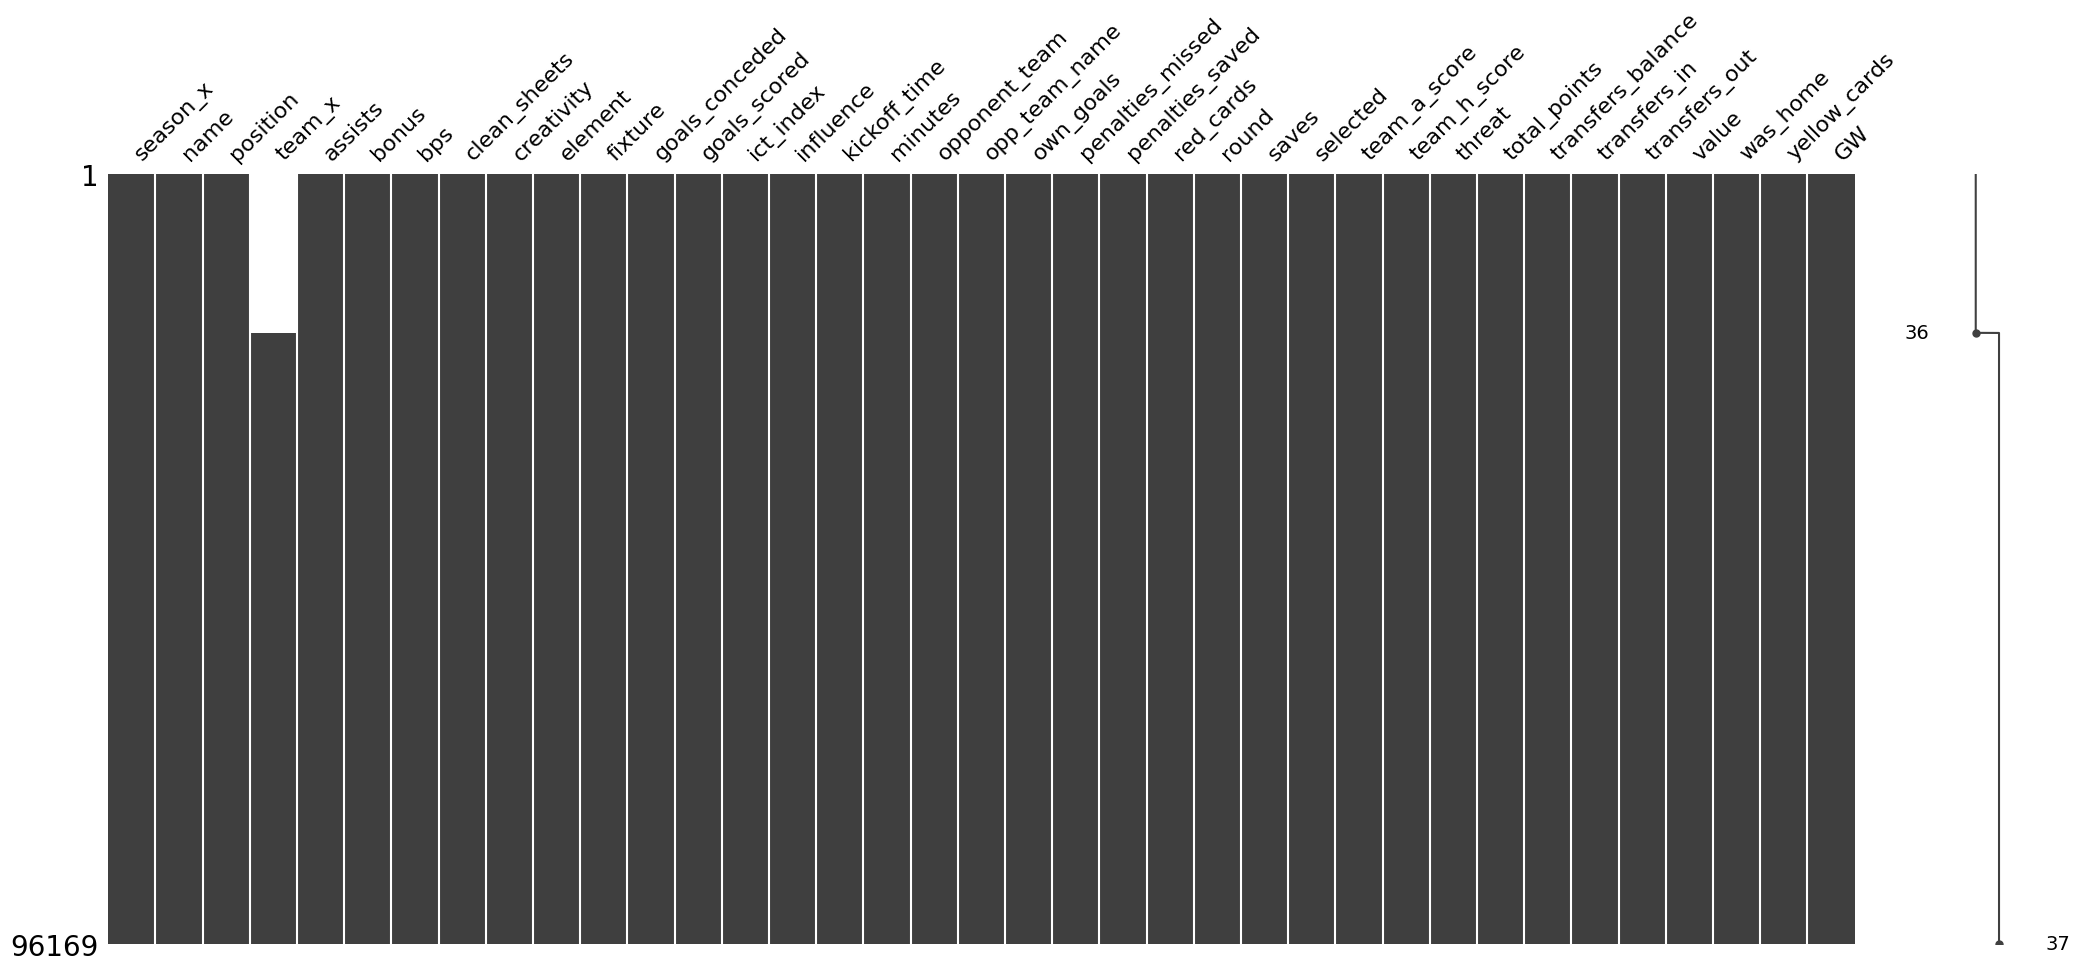

In [7]:
msno.matrix(df)

In [8]:
# Fill missing team names with 'Unknown'
df['team_x'] = df['team_x'].fillna('Unknown')

<Axes: >

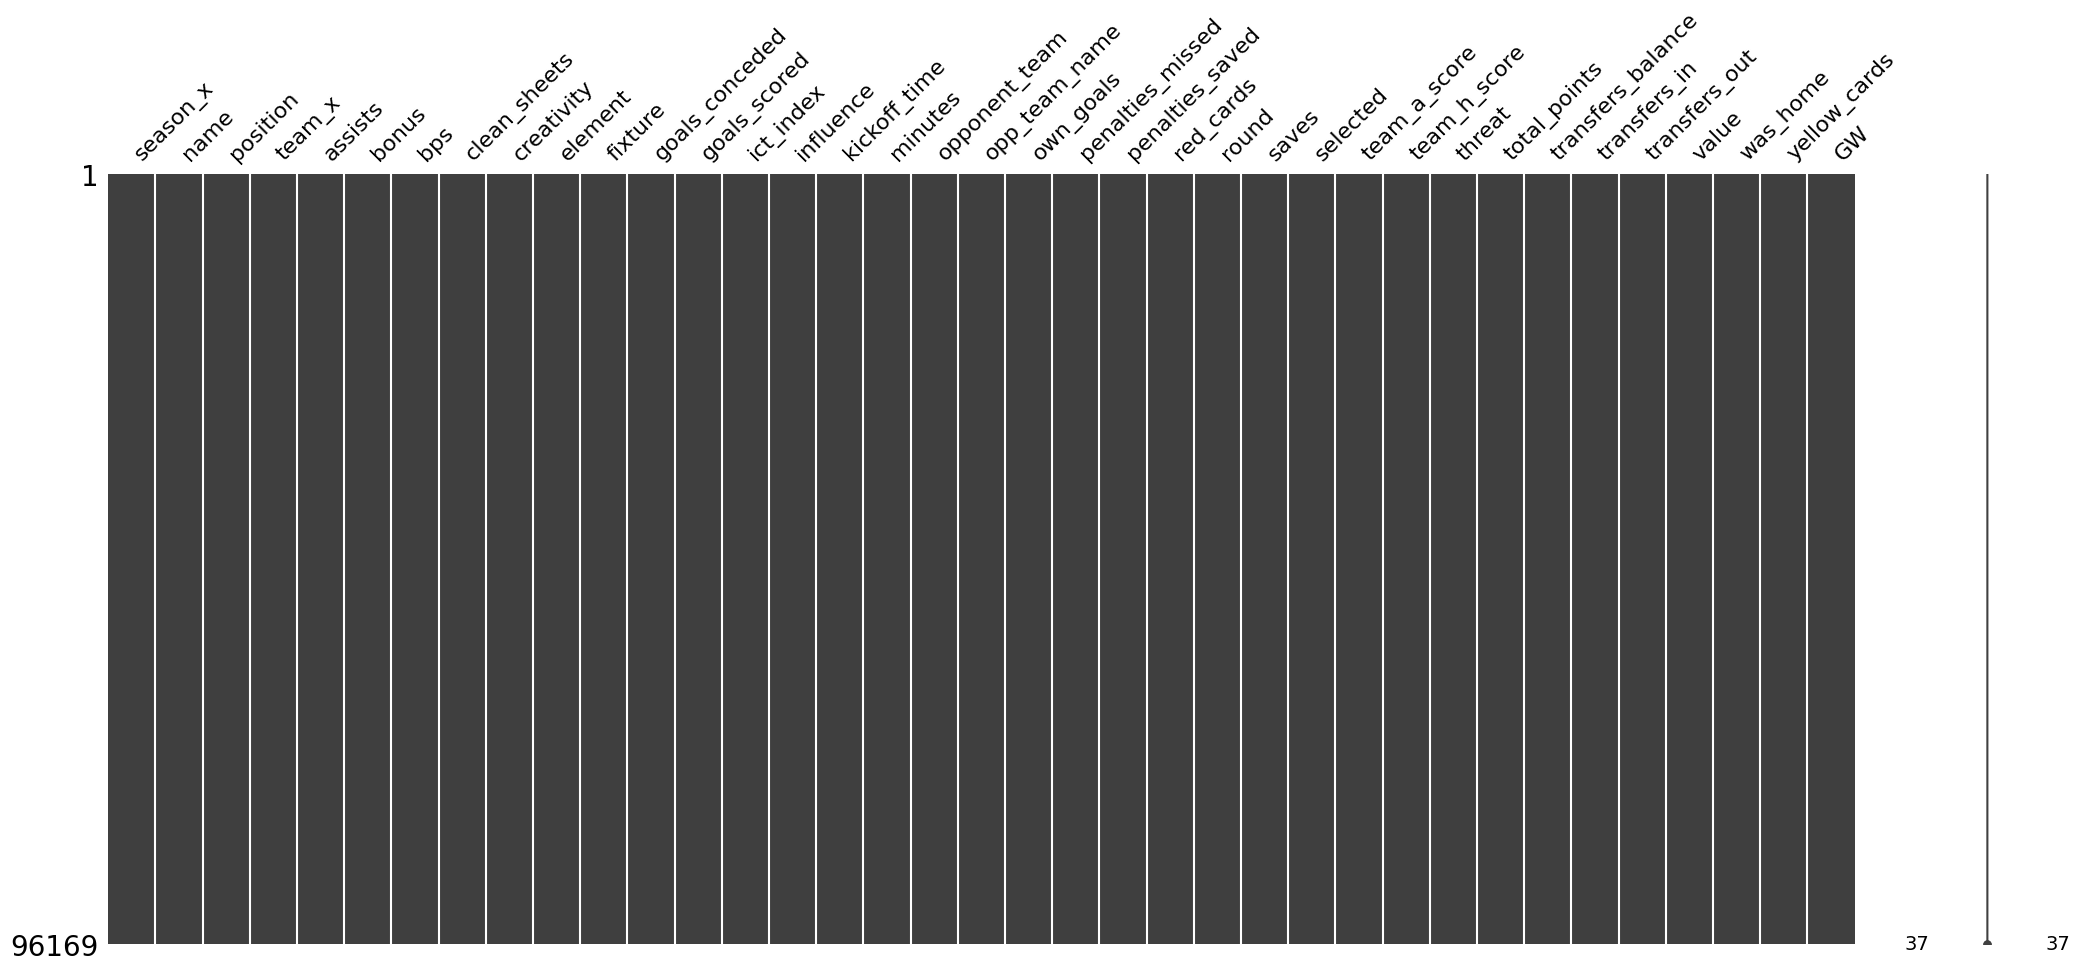

In [9]:
msno.matrix(df)

## 1️⃣ Data Cleaning
We begin by ensuring data quality before modeling.

### Why this step matters
Predictive models rely on accurate and consistent input features.  
Dirty data (nulls, duplicates, mixed types) can mislead both neural networks and tree-based models.

### Cleaning steps
- **Remove irrelevant columns:** e.g. `transfers_in/out`, `selected_by_percent` – these reflect player popularity, not performance.  
- **Handle missing values:** impute or drop as appropriate (many NaNs appear in unused columns).  
- **Fix data types:** ensure all numerical metrics are floats or ints.  
- **Drop duplicates:** to maintain one record per player per gameweek.  
- **Normalize column names:** lower case, underscores.

By cleaning first, we ensure a stable dataset for all downstream transformations.

In [10]:
# STEP 1: DATA CLEANING

print(f"Original dataset shape: {original_data}")

# Remove duplicates if any
df_cleaned = df.drop_duplicates()
print(f"After removing duplicates: {df_cleaned.shape}")

Original dataset shape: (96169, 37)
After removing duplicates: (96169, 37)


In [11]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print("\nDuplicate rows:")
    print(df[df.duplicated(keep=False)])

Number of duplicate rows: 0


In [12]:

print(f"Original dataset shape: {original_data}")

# Drop rows where any of the main columns (name, team_x, position, GW) are null
df_cleaned = df.dropna(subset=['name', 'team_x', 'position', 'GW'])

# Summary statistics before cleaning
print(f"After removing duplicates: {df_cleaned.shape}")

Original dataset shape: (96169, 37)
After removing duplicates: (96169, 37)


In [13]:
print(df['position'].value_counts())

position
MID    39163
DEF    33683
FWD    12669
GK     10553
GKP      101
Name: count, dtype: int64


In [14]:
df['position'] = df['position'].replace('GKP', 'GK')

In [15]:
print(df['position'].value_counts())

position
MID    39163
DEF    33683
FWD    12669
GK     10654
Name: count, dtype: int64


In [16]:
print((df['GW'] == df['round']).all())

True


In [17]:
df = df.drop(columns=['round'])

In [18]:
print(df.columns.tolist())

['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW']


In [19]:
# Create the directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

# Save cleaned dataset inside the 'data' folder directly (not inside 'raw')
df.to_csv("../data/cleaned_merged_seasons.csv", index=False)

print("✅ Cleaned dataset saved successfully in the data folder!")

✅ Cleaned dataset saved successfully in the data folder!


In [20]:
df = pd.read_csv("../data/cleaned_merged_seasons.csv")
df = df.sort_values(['name', 'season_x', 'GW']).copy()

df['form'] = (
    df.groupby(['name','season_x'])['total_points']
      .transform(lambda s: s.shift(1).rolling(window=4, min_periods=1).mean() / 10)
)

player = df['name'].iloc[0]  
check = df[df['name'] == player][['season_x','GW','total_points','form']].head(20)
print(player)
print(check)

Aaron Connolly
      season_x  GW  total_points      form
19852  2020-21   1             1       NaN
20277  2020-21   2             8  0.100000
20816  2020-21   3             2  0.450000
21370  2020-21   4             2  0.366667
21932  2020-21   5             4  0.325000
22519  2020-21   6             0  0.400000
23109  2020-21   7             0  0.200000
23706  2020-21   8             1  0.150000
24306  2020-21   9             0  0.125000
24907  2020-21  10             2  0.025000
25510  2020-21  11             2  0.075000
26051  2020-21  12             1  0.125000
26658  2020-21  13             0  0.125000
27265  2020-21  14             2  0.125000
27876  2020-21  15             0  0.125000
28489  2020-21  16             0  0.075000
28981  2020-21  17             5  0.050000
29539  2020-21  18             0  0.175000
29939  2020-21  19             0  0.125000
30892  2020-21  20             0  0.125000


invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


In [21]:
df.to_csv("../data/cleaned_merged_seasons.csv", index=False)

### Positional Scoring Trends
Different positions contribute differently to fantasy outcomes.

- **Midfielders** often dominate due to both attacking (goals, assists) and defensive (clean sheets) points.  
- **Forwards** rely on goal output but get fewer assist or clean sheet bonuses.  
- **Defenders** benefit from clean sheets but score less often.  
- **Goalkeepers** gain steady points through saves but less variation.

Plotting the average total points per position highlights which role tends to deliver the most fantasy value.

position
MID    11384.4
DEF     8705.2
FWD     3975.8
GK      2463.2
Name: total_points, dtype: float64


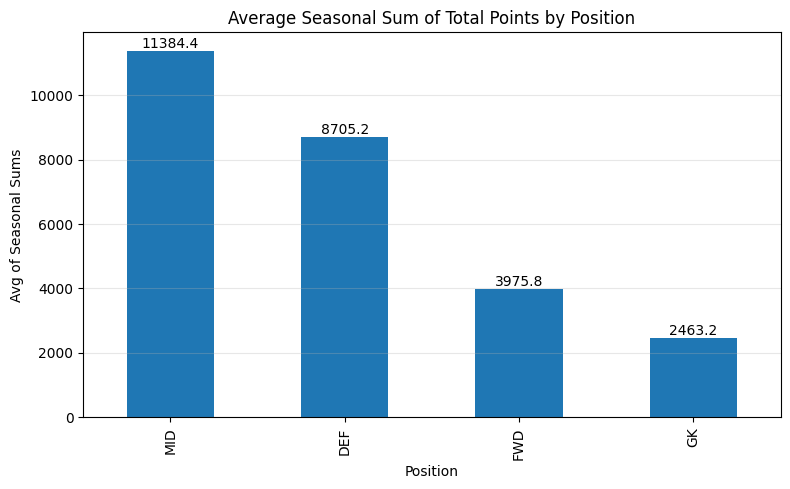

In [22]:
per_season_points = (
    df.groupby(['season_x', 'position'])['total_points']
      .sum()
      .reset_index()
)

position_avg_season_sum = (
    per_season_points.groupby('position')['total_points']
      .mean()
      .sort_values(ascending=False)

)

print(position_avg_season_sum)



bars = position_avg_season_sum.plot(kind='bar', figsize=(9,5))
plt.title('Average Seasonal Sum of Total Points by Position')
plt.xlabel('Position'); plt.ylabel('Avg of Seasonal Sums')
plt.grid(axis='y', alpha=0.3)
plt.bar_label(bars.containers[0])

plt.show()

Top 5 players by total points during the 2022-23 season:
name
Erling Haaland     272
Harry Kane         263
Mohamed Salah      239
Martin Ødegaard    212
Marcus Rashford    205
Name: total_points, dtype: int64


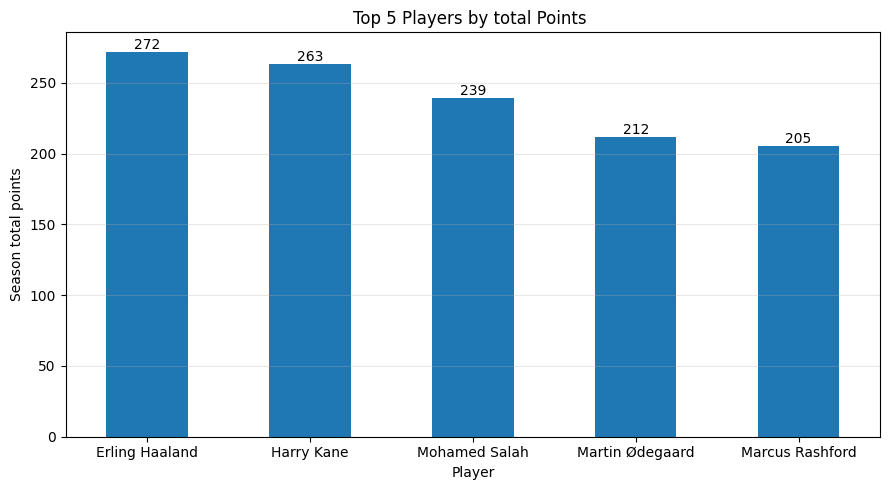

In [23]:
season_df = df[df['season_x'] == '2022-23'].copy()

top5_points = (
    season_df.groupby('name')['total_points']
             .sum()
             .sort_values(ascending=False)
             .head(5)
)


print("Top 5 players by total points during the 2022-23 season:")
print(top5_points)

ax = top5_points.plot(kind='bar', figsize=(9,5))
plt.title(f'Top 5 Players by total Points ')
plt.xlabel('Player'); plt.ylabel('Season total points')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.bar_label(ax.containers[0])  
plt.tight_layout()
plt.show()

## 2️⃣ Feature Engineering and Data-Engineering Questions

### Why engineer new features?
Raw data rarely captures dynamic player momentum.  
We introduce **form**, representing a player's recent performance trend.

\[
\text{form} = \frac{\text{average total points over last 4 gameweeks}}{10}
\]

This quantifies short-term consistency — crucial for predicting future outcomes in fantasy football.

### Data-Engineering Questions

1. **Which player positions score the most on average across seasons?**  
   → Helps us understand role-based contribution (Goalkeepers vs. Defenders vs. Midfielders vs. Forwards).

2. **How does the “form” of top players evolve across gameweeks (2022–23)?**  
   → Reveals whether the most consistent performers are also the ones earning the highest cumulative points.

Top 5 by the average form:
name
Erling Haaland              0.762838
Harry Kane                  0.652928
Mohamed Salah               0.638063
Martin Ødegaard             0.565541
Gabriel Martinelli Silva    0.561712
Name: form, dtype: float64


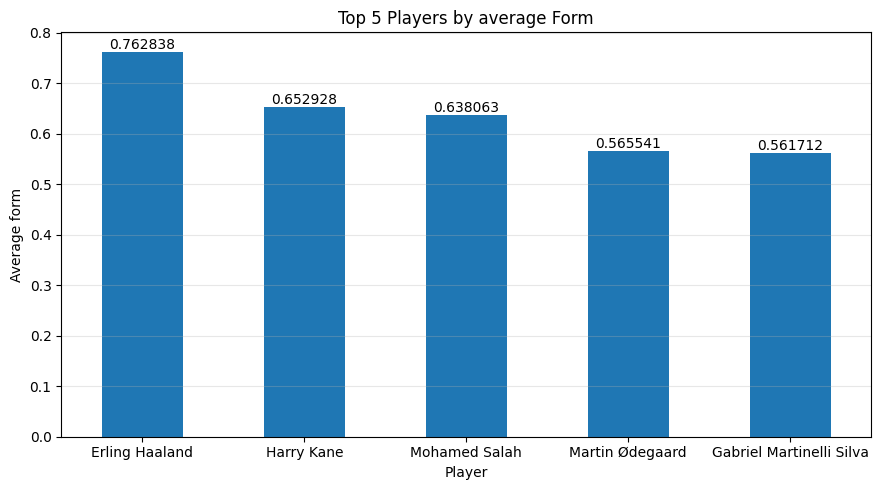

In [24]:

top5_form = (
    season_df.groupby('name')['form']
             .mean()
             .sort_values(ascending=False)
             .head(5)
)

print("Top 5 by the average form:")
print(top5_form)

ax = top5_form.plot(kind='bar', figsize=(9,5))
plt.title(f'Top 5 Players by average Form')
plt.xlabel('Player'); plt.ylabel('Average form')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.bar_label(ax.containers[0])  
plt.tight_layout()
plt.show()

In [25]:

common_players = set(top5_form.index) & set(top5_points.index)
print("Players in both lists:", common_players if common_players else "None")

Players in both lists: {'Martin Ødegaard', 'Erling Haaland', 'Mohamed Salah', 'Harry Kane'}


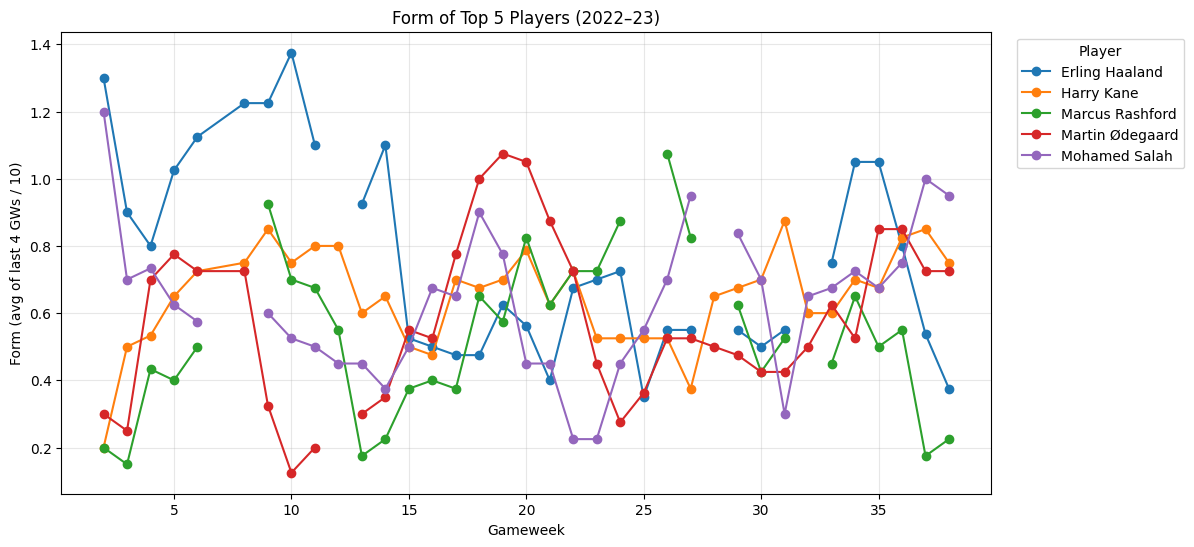

In [26]:
names = list(top5_points.index)
wide = season_df[season_df['name'].isin(names)].pivot_table(
    index='GW', columns='name', values='form'
)
ax = wide.plot(figsize=(12,6), marker='o')
plt.title('Form of Top 5 Players (2022–23)')
plt.xlabel('Gameweek'); plt.ylabel('Form (avg of last 4 GWs / 10)')
plt.legend(title='Player', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

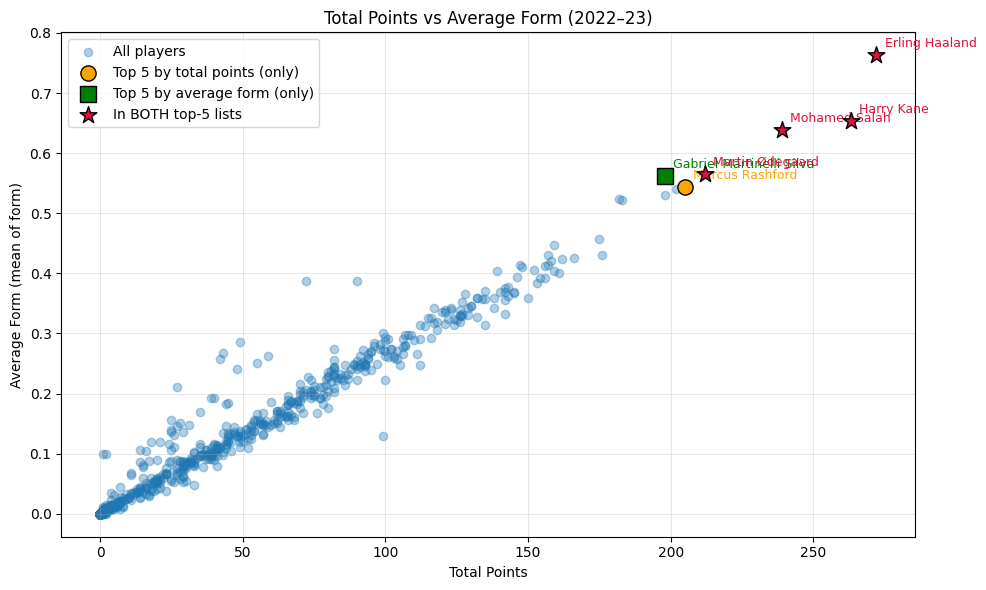

In [27]:


season_totals = season_df.groupby('name')['total_points'].sum()
season_form   = season_df.groupby('name')['form'].mean()

# sets
both   = set(top5_points.index) & set(top5_form.index)
only_p = set(top5_points.index) - both     
only_f = set(top5_form.index)   - both    

plt.figure(figsize=(10,6))

plt.scatter(season_totals, season_form, alpha=0.35, label='All players', zorder=1)


if only_p:
    plt.scatter(season_totals[list(only_p)], season_form[list(only_p)],
                s=120, color='orange', edgecolors='black', linewidth=1.0,
                label='Top 5 by total points (only)', zorder=3)

if only_f:
    plt.scatter(season_totals[list(only_f)], season_form[list(only_f)],
                s=120, color='green', marker='s', edgecolors='black', linewidth=1.0,
                label='Top 5 by average form (only)', zorder=3)


if both:
    plt.scatter(season_totals[list(both)], season_form[list(both)],
                s=160, color='crimson', marker='*', edgecolors='black', linewidth=1.0,
                label='In BOTH top-5 lists', zorder=4)


def annotate(names, color):
    for name in names:
        x, y = season_totals[name], season_form[name]
        plt.annotate(name, (x, y), xytext=(6,6), textcoords='offset points',
                     fontsize=9, color=color)

annotate(only_p, 'orange')
annotate(only_f, 'green')
annotate(both,   'crimson')

plt.title('Total Points vs Average Form (2022–23)')
plt.xlabel('Total Points'); plt.ylabel('Average Form (mean of form)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

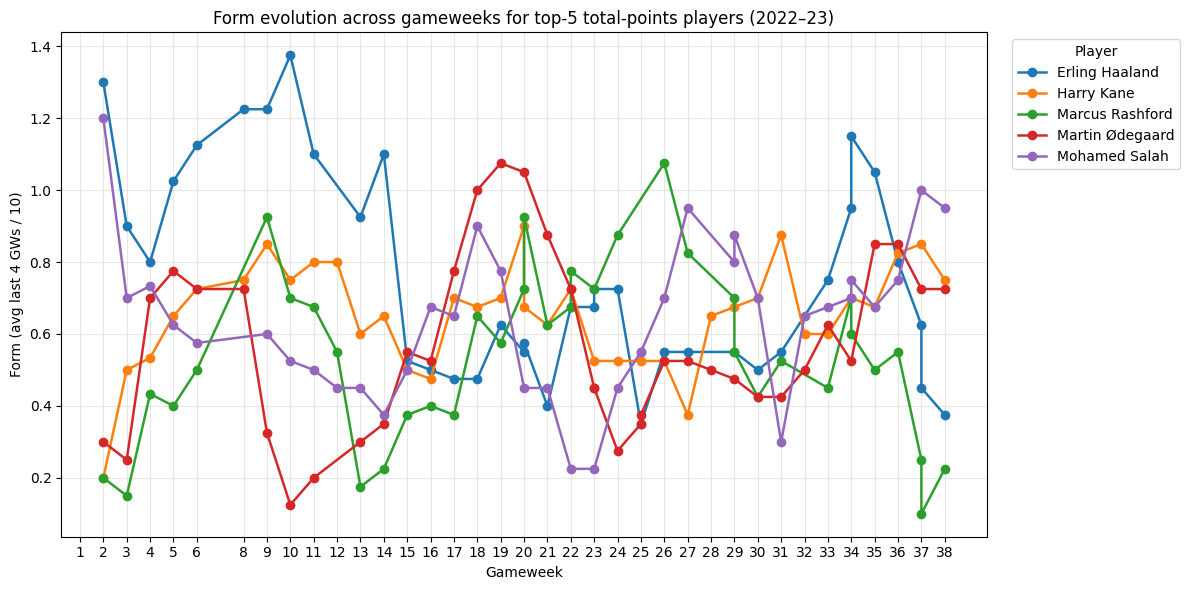

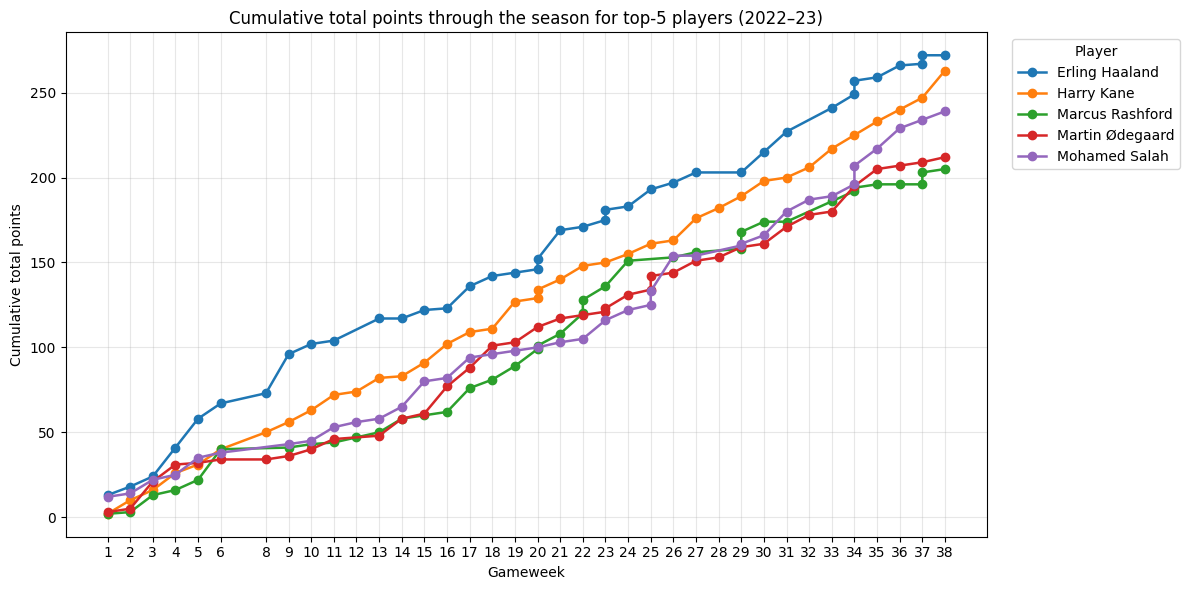

In [28]:


players_to_plot = list(top5_points.index)  
plot_df = (
    season_df[season_df["name"].isin(players_to_plot)]
    .copy()
    .sort_values(["name", "GW"])
)


plt.figure(figsize=(12,6))
for name, g in plot_df.groupby("name"):
    plt.plot(g["GW"], g["form"], marker="o", linewidth=1.8, label=name)

plt.title("Form evolution across gameweeks for top-5 total-points players (2022–23)")
plt.xlabel("Gameweek")
plt.ylabel("Form (avg last 4 GWs / 10)")
plt.grid(alpha=0.3)
plt.legend(title="Player", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xticks(sorted(plot_df["GW"].dropna().unique()))
plt.tight_layout()
plt.show()


cum_df = plot_df.copy()
cum_df["cum_points"] = cum_df.groupby("name")["total_points"].cumsum()

plt.figure(figsize=(12,6))
for name, g in cum_df.groupby("name"):
    plt.plot(g["GW"], g["cum_points"], marker="o", linewidth=1.8, label=name)

plt.title("Cumulative total points through the season for top-5 players (2022–23)")
plt.xlabel("Gameweek")
plt.ylabel("Cumulative total points")
plt.grid(alpha=0.3)
plt.legend(title="Player", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xticks(sorted(cum_df["GW"].dropna().unique()))
plt.tight_layout()
plt.show()

In [29]:
os.makedirs("../data", exist_ok=True)


season_choice = "2022-23"  


top5_points.to_csv(f"../data/top5_by_total_points_{season_choice}.csv", index=False)
top5_form.to_csv(f"../data/top5_by_average_form_{season_choice}.csv", index=False)

print("Saved:")
print(f" - ../data/top5_by_total_points_{season_choice}.csv")
print(f" - ../data/top5_by_average_form_{season_choice}.csv")

Saved:
 - ../data/top5_by_total_points_2022-23.csv
 - ../data/top5_by_average_form_2022-23.csv


In [30]:
df = pd.read_csv("../data/cleaned_merged_seasons.csv")


df_sorted = df.sort_values(["name", "season_x", "GW"]).copy()


df_sorted["upcoming_total_points"] = (
    df_sorted.groupby(["name", "season_x"])["total_points"].shift(-1)
)


before = len(df_sorted)
df_model = df_sorted.dropna(subset=["upcoming_total_points"]).copy()
after = len(df_model)

print("Target created: 'upcoming_total_points'")
print("Rows dropped (dropping NaNs):", before - after)


df_model[["name", "season_x", "GW", "total_points", "upcoming_total_points"]].head(10)

Target created: 'upcoming_total_points'
Rows dropped (dropping NaNs): 2782


,name,season_x,GW,total_points,upcoming_total_points
0,Aaron Connolly,2020-21,1,1,8.0
1,Aaron Connolly,2020-21,2,8,2.0
2,Aaron Connolly,2020-21,3,2,2.0
3,Aaron Connolly,2020-21,4,2,4.0
4,Aaron Connolly,2020-21,5,4,0.0
5,Aaron Connolly,2020-21,6,0,0.0
6,Aaron Connolly,2020-21,7,0,1.0
7,Aaron Connolly,2020-21,8,1,0.0
8,Aaron Connolly,2020-21,9,0,2.0
9,Aaron Connolly,2020-21,10,2,2.0


## 3️⃣ Feature Selection and Preprocessing

### Chosen Features
We selected a comprehensive set of **match-related** and **player-related** attributes that directly or indirectly influence Fantasy Premier League (FPL) points.  
These were chosen based on domain understanding of how FPL scoring works, as well as statistical correlation with total points in exploratory analysis.

---

### ⚽ Match-Related Features
| Feature | Type | Reason for Inclusion |
|----------|------|----------------------|
| `assists` | Match | Directly contributes to FPL points for creative players. |
| `bonus` | Match | Bonus points reflect overall match performance beyond goals/assists (FPL BPS system). |
| `bps` | Match | The “Bonus Point System” score — captures all-round contributions such as tackles, passes, and key involvements. |
| `clean_sheets` | Match | Important for defenders and goalkeepers; directly adds points in FPL. |
| `goals_conceded` | Match | Penalizes defenders/goalkeepers when their teams concede goals. |
| `goals_scored` | Match | The strongest positive contributor to fantasy points, especially for forwards and midfielders. |
| `minutes` | Match | Determines eligibility; players must play at least 60 minutes for full appearance points. |
| `own_goals` | Match | Negative scoring event that directly reduces FPL points. |
| `penalties_missed` | Match | Penalizes players for missed spot-kicks; crucial for attackers. |
| `penalties_saved` | Match | Rewards goalkeepers heavily; one of the biggest point spikes in FPL. |
| `red_cards` | Match | Major disciplinary event causing negative points and missed future games. |
| `saves` | Match | Key for goalkeepers; each set of 3 saves adds 1 FPL point. |
| `yellow_cards` | Match | Smaller disciplinary penalty but common across all positions. |
| `was_home` | Match | Binary indicator — players tend to perform better in home matches due to crowd support and familiarity. |
| `team_h_score` | Match | Encodes the team’s attacking output in home fixtures. |
| `team_a_score` | Match | Encodes the team’s attacking output in away fixtures. |
| `fixture` | Match | Categorical identifier representing the match ID, capturing game context. |
| `GW` | Match | Gameweek number; allows temporal modeling and helps with the engineered `form` feature. |

---

### 👟 Player-Related Features
| Feature | Type | Reason for Inclusion |
|----------|------|----------------------|
| `position` | Player | Encodes player role (GK/DEF/MID/FWD) — influences how points are awarded (e.g., clean sheets vs. goals). |
| `creativity` | Player | FPL’s metric of a player’s chance-creation ability; correlates with assists. |
| `influence` | Player | Measures how involved a player is in key actions, often aligned with bonus points. |
| `threat` | Player | Quantifies attacking potential — high for forwards and wingers. |
| `ict_index` | Player | Composite of Influence, Creativity, and Threat; summarizes attacking and defensive impact. |
| `value` | Player | Reflects market valuation; correlates with consistency and reliability over the season. |
| `form` | Engineered | Rolling average of recent points — captures short-term performance momentum. |
| `selected` | Player | Proportion of managers owning the player; proxy for crowd confidence and player popularity trends. |

---

### 🧠 Why These Features
- **Comprehensive coverage:** The chosen features reflect all aspects of FPL scoring — attacking, defensive, and disciplinary.  
- **Causally linked:** Each variable either directly contributes to fantasy points (e.g., `goals_scored`, `assists`) or indirectly influences them (e.g., `bps`, `minutes`, `form`).  
- **Interpretable:** Metrics like `creativity`, `influence`, and `threat` allow explainable AI tools (SHAP/LIME) to provide meaningful insights.  
- **Predictive diversity:** By mixing raw match stats and cumulative indices, the model can learn both micro (single-game) and macro (player trend) patterns.

---

### ⚙️ Preprocessing Steps
- **Label Encoding** → converts `position` and other categorical variables into numeric form.  
- **Feature Scaling** → normalizes continuous values (`StandardScaler` or `MinMaxScaler`) to improve neural network convergence.  
- **Train-Test Split** → ensures unbiased evaluation on unseen data.  
- **Feature Consistency Check** → aligns input columns for all models (FFNN and Random Forest).  

This balanced feature set ensures that the model captures *both tactical performance and player form dynamics*, offering predictive power with interpretability.

In [31]:
match_features = [
    "assists", "bonus", "bps", "clean_sheets", "goals_conceded",
    "goals_scored", "minutes", "own_goals", "penalties_missed",
    "penalties_saved", "red_cards", "saves", "yellow_cards",
    "was_home", "team_h_score", "team_a_score", "fixture", "GW"
]


player_features = [
    "position", "creativity", "influence", "threat",
    "ict_index", "value", "form", "selected"
]

features = match_features + player_features

In [32]:

df_enc = pd.get_dummies(df_model, columns=["position"], prefix="pos")
pos_cols = [c for c in df_enc.columns if c.startswith("pos_")]
features_final = [c for c in features if c != "position"] + pos_cols


df_enc[features_final] = df_enc[features_final].fillna(0)

X = df_enc[features_final].copy()
y = df_enc["upcoming_total_points"].astype(float).copy()

print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (93387, 29) | y shape: (93387,)


Correlation of all features:
 minutes             0.477763
form                0.418052
ict_index           0.404483
bps                 0.399808
influence           0.374968
creativity          0.314187
value               0.312058
threat              0.307431
selected            0.274587
goals_conceded      0.269043
clean_sheets        0.239553
bonus               0.181703
goals_scored        0.177151
assists             0.149466
saves               0.124371
yellow_cards        0.117216
penalties_missed    0.035789
pos_FWD             0.028739
own_goals           0.024055
pos_MID             0.024052
penalties_saved     0.015186
team_h_score        0.011252
team_a_score       -0.001656
was_home           -0.016303
red_cards          -0.017656
pos_DEF            -0.024978
pos_GK             -0.030644
fixture            -0.032339
GW                 -0.035828
Name: upcoming_total_points, dtype: float64


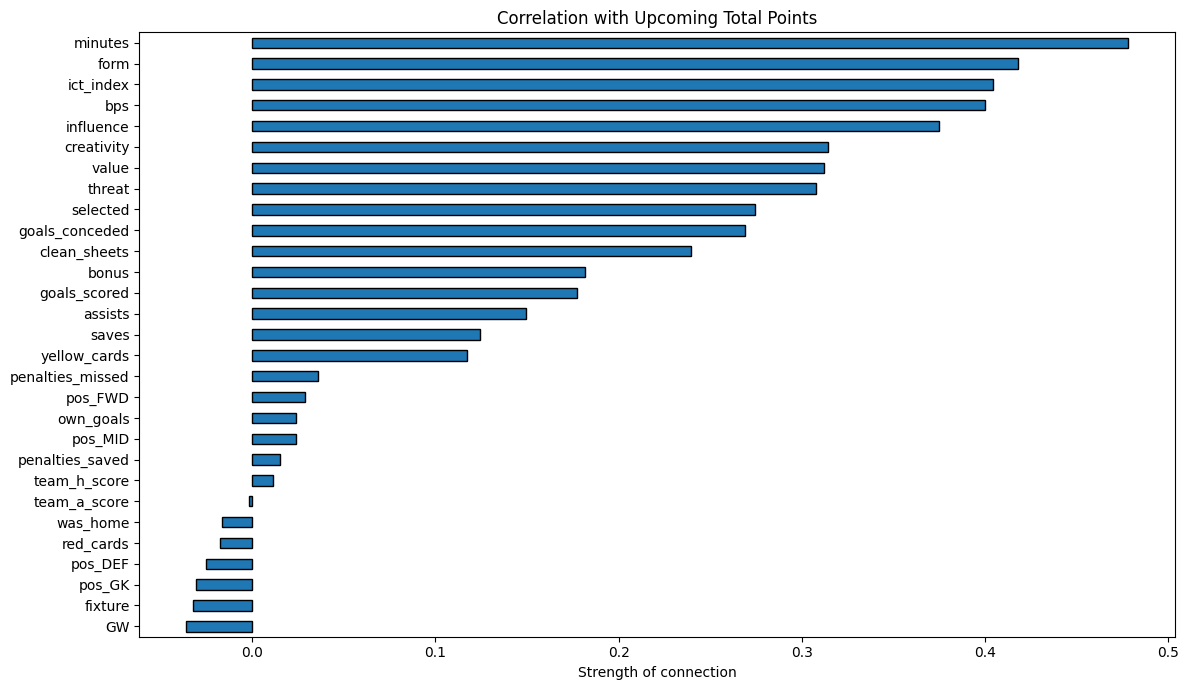

Features with no variation: None


In [33]:

target = "upcoming_total_points"

# Make sure all features are numeric and filled 
df_enc[features_final] = (
    df_enc[features_final]
      .apply(pd.to_numeric, errors="coerce")
      .fillna(0)
)

# Correlation with the target for ALL features 
corr_all = df_enc[features_final + [target]].corr(numeric_only=True)[target]
corr_all = corr_all.reindex(features_final).fillna(0) 


print("Correlation of all features:\n", corr_all.sort_values(ascending=False))


# Plot 
plt.figure(figsize=(12,7))
corr_all.sort_values().plot(kind="barh", edgecolor="black")
plt.title("Correlation with Upcoming Total Points")
plt.xlabel("Strength of connection")
plt.tight_layout()
plt.show()



zero_var = [c for c in features_final if df_enc[c].nunique() <= 1]
print("Features with no variation:", zero_var if zero_var else "None")

In [34]:
# Fill missing values
X = X.fillna(0)

# Feature engineering
df_enc["performance_momentum"] = df_enc["form"] * (df_enc["minutes"] / 90)

if "performance_momentum" not in features_final:
    features_final.append("performance_momentum")

corr_check = df_enc[["performance_momentum", "upcoming_total_points"]].corr().iloc[0,1]
print(f"Correlation between performance_momentum and upcoming_total_points: {corr_check:.3f}")


df_enc["recent_performance_index"] = (df_enc["form"] * df_enc["minutes"]) + df_enc["bps"] + df_enc["bonus"]

if "recent_performance_index" not in features_final:
    features_final.append("recent_performance_index")

# check correlation
corr_check = df_enc[["recent_performance_index", "upcoming_total_points"]].corr().iloc[0,1]
print(f"Correlation between recent_performance_index and upcoming_total_points: {corr_check:.3f}")



# Update X and re-split
X = df_enc[features_final].copy()
y = df_enc["upcoming_total_points"].copy()

Correlation between performance_momentum and upcoming_total_points: 0.426
Correlation between recent_performance_index and upcoming_total_points: 0.463


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train rows:", X_train.shape[0], "| Test rows:", X_test.shape[0])

Train rows: 74709 | Test rows: 18678


Before scaling (value): min = 37.000, max = 133.000
After scaling (value):  min = -1.138, max = 6.455


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


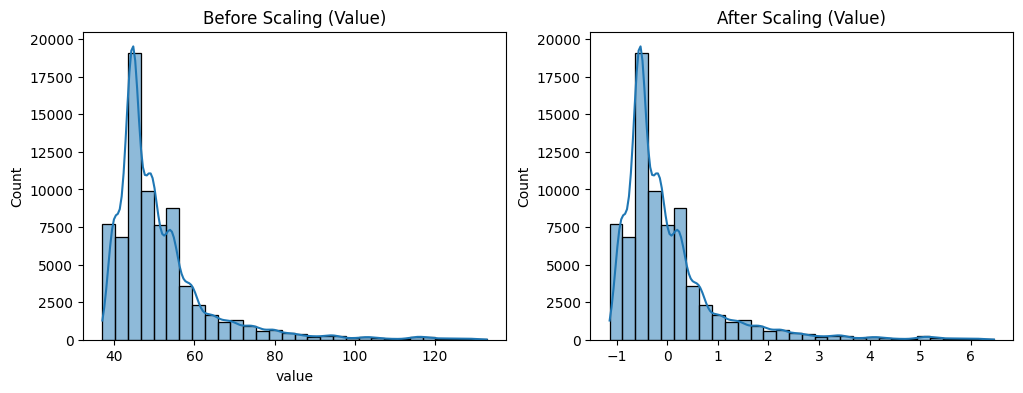

In [36]:
col_index = X_train.columns.get_loc("value")

print(f"Before scaling (value): min = {X_train['value'].min():.3f}, max = {X_train['value'].max():.3f}")
print(f"After scaling (value):  min = {X_train_scaled[:, col_index].min():.3f}, max = {X_train_scaled[:, col_index].max():.3f}")



fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(X_train["value"], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Before Scaling (Value)")
sns.histplot(X_train_scaled[:, X_train.columns.get_loc("value")], bins=30, kde=True, ax=ax[1])
ax[1].set_title("After Scaling (Value)")
plt.show()

## 4️⃣ Predictive Modeling

We implement and compare:
1. **Random Forest Regressor** – interpretable and robust baseline.  
2. **Feedforward Neural Network (FFNN)** – a flexible non-linear learner.

### Why both?
The Random Forest captures non-linearities without scaling, serving as a benchmark.  
The FFNN can approximate more complex interactions, allowing fine-tuned performance gains.

### 🌲 Random Forest — Incremental Training & Model Selection

We train a **RandomForestRegressor** incrementally using `warm_start=True` and an increasing number of trees (`n_estimators ∈ {20, 40, 60, 80, 100}`).

**Why this setup?**
- **warm_start=True** lets us *grow the same forest* by adding trees without reinitializing, making the experiment efficient and consistent.
- We monitor **Train R²**, **Validation R²** (on `X_test` here), and **Validation MAE** to:
  - check **under/overfitting** (Train vs. Val gap),
  - choose a **good n_estimators** (marginal gains vs time).

**Key hyperparameters**
- `max_depth=10`: limits tree depth → reduces variance (overfitting) while keeping non-linearity.
- `min_samples_split=6`, `min_samples_leaf=3`: regularize small leaves and noisy splits.
- `max_features='sqrt'`: decorrelates trees and improves generalization.
- `random_state=42`: reproducibility; `n_jobs=-1`: use all cores.

**What to look for in the console log**
- As trees increase, expect **Val R²** to improve then plateau.
- If **Train R² ≫ Val R²**, the forest is overfitting → deeper trees or too many trees can cause variance.
- **Val MAE** gives an absolute-error view (lower is better) complementary to R².

We also record **total training time** to assess the cost/benefit of growing more trees.

In [37]:
from sklearn.ensemble import RandomForestRegressor
import time

print("Random Forest Training Progress")

start = time.time()
rf_progress = RandomForestRegressor(
    n_estimators=0,           
    warm_start=True,          
    max_depth=10,
    min_samples_split=6,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

train_r2, val_r2, val_mae = [], [], []
n_trees = [20, 40, 60, 80, 100]

for n in n_trees:
    rf_progress.n_estimators = n
    rf_progress.fit(X_train, y_train)
    
   
    y_pred_train = rf_progress.predict(X_train)
    y_pred_val = rf_progress.predict(X_test)
    
 
    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_test, y_pred_val)
    mae_val = mean_absolute_error(y_test, y_pred_val)
    
    train_r2.append(r2_train)
    val_r2.append(r2_val)
    val_mae.append(mae_val)
    print(f"Epoch {len(train_r2):2d} | Trees: {n:3d} | Train R²: {r2_train:.3f} | Val R²: {r2_val:.3f} | Val MAE: {mae_val:.3f}")



# Time taken
eval_time = time.time() - start
    
print("Random Forest trained successfully")
print(f"Eval Time: {eval_time:.2f} sec")

Random Forest Training Progress
Epoch  1 | Trees:  20 | Train R²: 0.351 | Val R²: 0.291 | Val MAE: 1.202
Epoch  2 | Trees:  40 | Train R²: 0.355 | Val R²: 0.292 | Val MAE: 1.201
Epoch  3 | Trees:  60 | Train R²: 0.355 | Val R²: 0.293 | Val MAE: 1.201
Epoch  4 | Trees:  80 | Train R²: 0.355 | Val R²: 0.293 | Val MAE: 1.201
Epoch  5 | Trees: 100 | Train R²: 0.356 | Val R²: 0.294 | Val MAE: 1.201
Random Forest trained successfully
Eval Time: 2.85 sec


### ✅ Final Evaluation — Random Forest (Test Set)

After deciding on the forest (last grown state), we refit on `X_train` and evaluate on **unseen** `X_test`.

**Reported metrics**
- **MAE**: average absolute error in predicted points (✅ easy to interpret; lower is better).
- **MSE / RMSE**: square error and its root (penalize large mistakes more; RMSE in the same units as points).
- **R²**: proportion of variance explained (higher is better).  
  - R² ≈ 0 means predictions are no better than the mean.
  - Negative R² indicates worse than a naive baseline.

**How to read them**
- Compare these to FFNN v1/v2 results to decide the best model.
- If **MAE is small** but **R² is modest**, the model is good at typical cases but struggles on high-variance weeks (hat-tricks, penalty saves, etc.).
- If **RMSE ≫ MAE**, there are outliers (big errors on rare events)—expected in FPL due to explosive weeks.

This block prints a clean summary for quick reporting.

In [38]:
#Evaluation Metrics
rf_progress.fit(X_train, y_train)
y_pred_rf = rf_progress.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)


print("Random Forest Evaluation Results")
print("-----------------------------------")
print(f"MAE   : {mae:.4f}")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")

Random Forest Evaluation Results
-----------------------------------
MAE   : 1.2013
MSE   : 4.5665
RMSE  : 2.1369
R²    : 0.2937


Warm-start fitting without increasing n_estimators does not fit new trees.


In [39]:
# ================== PREP: Build Random Forest metrics dicts from existing variables ==================
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# You already computed these for TEST: mae, mse, rmse, r2 (keep them as-is)
rf_test_metrics = {
    "MAE": float(mae),
    "MSE": float(mse),
    "RMSE": float(rmse),
    "R2": float(r2),
}

# Also compute TRAIN metrics to complete the comparison
y_pred_rf_train = rf_progress.predict(X_train)
_mae_tr = mean_absolute_error(y_train, y_pred_rf_train)
_mse_tr = mean_squared_error(y_train, y_pred_rf_train)
_rmse_tr = float(np.sqrt(_mse_tr))
_r2_tr = r2_score(y_train, y_pred_rf_train)

rf_train_metrics = {
    "MAE": float(_mae_tr),
    "MSE": float(_mse_tr),
    "RMSE": float(_rmse_tr),
    "R2": float(_r2_tr),
}

print("rf_train_metrics:", rf_train_metrics)
print("rf_test_metrics :", rf_test_metrics)

rf_train_metrics: {'MAE': 1.164413647316877, 'MSE': 4.170129029282616, 'RMSE': 2.0420893783776006, 'R2': 0.3556562512877214}
rf_test_metrics : {'MAE': 1.2013050291244145, 'MSE': 4.566544254657815, 'RMSE': 2.1369474150427323, 'R2': 0.2936624930221312}


### 📈 Diagnostic Plots — Are RF Predictions Well-Behaved?

We visualize two classic diagnostics for regression:

1) **Actual vs. Predicted (scatter)**
- The red dashed line is the **ideal y = x** line.  
- **Tight cloud along the line** → strong predictive alignment.  
- **Systematic curve** (e.g., underpredicting at high points) → model bias; consider engineered features or different loss.

2) **Residuals Distribution (histogram + KDE)**
- Residual = Actual − Predicted.  
- **Centered near 0** and reasonably **symmetric** → unbiased errors.  
- **Long tails / skew** → occasional large misses (expected with rare high-point weeks).  
- If **multi-modal**, investigate subgroups (e.g., positions or home/away).

**What to do if diagnostics look off**
- Add temporal context (lags/rollings) → see FFNN v2 feature engineering.
- Consider fixture difficulty or opponent strength features.
- Tune tree depth and leaf constraints to balance bias/variance.

These plots complement scalar metrics and help explain *why* errors occur.

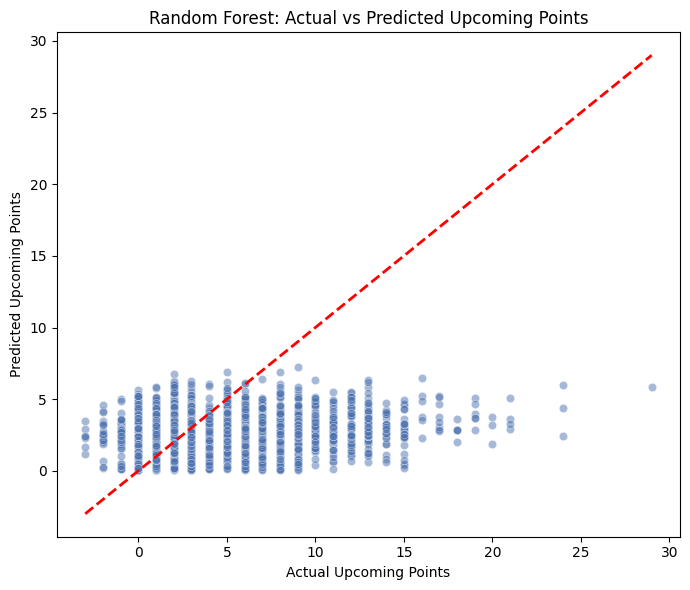

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


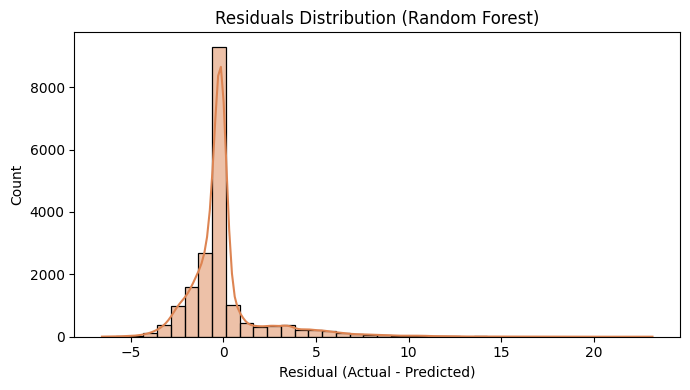

In [40]:
# Visualization

# Actual vs Predicted
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color="#4C72B0")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Random Forest: Actual vs Predicted Upcoming Points")
plt.xlabel("Actual Upcoming Points")
plt.ylabel("Predicted Upcoming Points")
plt.tight_layout()
plt.show()

# Residual distribution
residuals = y_test - y_pred_rf
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=40, kde=True, color="#DD8452")
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 🧮 Inference Function — Predict Upcoming FPL Points from Raw Stats

This cell defines `make_fpl_prediction(player_info, model_choice="Random Forest", show_all=False)`, a **production-style inference wrapper** that:
- **Validates input** against the exact feature schema used in training,
- **Recreates one-hot position columns** (`pos_GK`, `pos_DEF`, `pos_MID`, `pos_FWD`) to match the training design,
- **Reconstructs engineered features** if they existed in your training `X_train` (e.g., `goal_involvement`, `performance_momentum`, `recent_performance_index`),
- **Aligns column order** to `model_features = X_train.columns.tolist()` to avoid schema mismatch,
- Runs the selected model (**Random Forest** is enabled here) and prints a clean, human-readable summary.

#### ✅ Inputs (required keys)
The function enforces these fields in `player_info`:
`assists, bonus, bps, clean_sheets, goals_conceded, goals_scored, minutes, own_goals, penalties_missed, penalties_saved, red_cards, saves, yellow_cards, creativity, influence, threat, ict_index, value, selected, form, position`

> If any are missing, it raises a clear `ValueError` listing the missing keys.

#### 🔠 Position encoding
- We expect `position ∈ {GK, DEF, MID, FWD}` (case-insensitive).
- The function will populate `pos_*` dummy columns to mirror the training matrix.

#### 🧱 Feature matrix reconstruction
- Builds a zero-filled row with **exact training column names** and fills what’s present in `player_info`.
- This guarantees compatibility with the fitted model (`rf_progress`).

#### ⚙️ Model choice & output
- `model_choice="Random Forest"` (default) → uses `rf_progress.predict`.
- `show_all=True` would print a panel if you later add other models (e.g., `FFNN v1/v2`).

#### 🧠 Why this design?
- Prevents “X does not have valid feature names” errors (schema alignment).
- Keeps inference **leak-free and reproducible** by mirroring training preprocessing.
- Produces an explanation string that you can surface in a UI (or an API response).

> Tip: If you trained on **scaled** features or a `ColumnTransformer`, apply the **same transformer** here before prediction.

In [41]:
#Inference Function

def make_fpl_prediction(player_info, model_choice="Random Forest", show_all=False):
    """
    Predict upcoming FPL points for a given player using raw match statistics.
    Applies the same preprocessing used during training and returns
    a natural-language explanation of the prediction.
    """

   
    needed_features = [
        "assists", "bonus", "bps", "clean_sheets", "goals_conceded",
        "goals_scored", "minutes", "own_goals", "penalties_missed",
        "penalties_saved", "red_cards", "saves", "yellow_cards",
        "creativity", "influence", "threat", "ict_index",
        "value", "selected", "form", "position"
    ]
    missing = [f for f in needed_features if f not in player_info]
    if missing:
        raise ValueError(f"Missing player info fields: {missing}")

    # --- Create zero-filled feature row matching training data ---
    model_features = X_train.columns.tolist()
    feature_row = {col: 0 for col in model_features}

    # --- Fill numeric stats ---
    for key, val in player_info.items():
        if key in feature_row:
            feature_row[key] = val

    # --- Encode position (pos_DEF, pos_MID, etc.) ---
    position = player_info["position"].upper()
    for pos in ["GK", "DEF", "MID", "FWD"]:
        col_name = f"pos_{pos}"
        if col_name in feature_row:
            feature_row[col_name] = 1 if pos == position else 0

    # --- Recreate engineered features if present in training ---
    if "goal_involvement" in feature_row:
        feature_row["goal_involvement"] = (
            player_info.get("goals_scored", 0) + player_info.get("assists", 0)
        )

    if "performance_momentum" in feature_row:
        feature_row["performance_momentum"] = (
            player_info.get("form", 0) * (player_info.get("minutes", 0) / 90)
        )

    if "recent_performance_index" in feature_row:
        feature_row["recent_performance_index"] = (
            player_info.get("form", 0) * player_info.get("minutes", 0)
            + player_info.get("bps", 0)
            + player_info.get("bonus", 0)
        )

    # --- Convert to DataFrame ---
    X_input = pd.DataFrame([feature_row], columns=model_features).fillna(0)

    # --- Predict with Random Forest 
    preds = {}
    preds["Random Forest"] = rf_progress.predict(X_input)[0]

    # --- Output section ---
    if show_all:
        print("Predictions from all available models:")
        for model, pred in preds.items():
            print(f"• {model}: {pred:.2f} points")
        return preds
    else:
        prediction = preds[model_choice]
        position = player_info.get("position", "Unknown")
        minutes = player_info.get("minutes", "N/A")
        form = player_info.get("form", "N/A")
        print("--------------------------------------------------")
        print(f"📊 {model_choice} Prediction Summary")
        print("--------------------------------------------------")
        print(
            f"Based on the player's current week stats "
            f"(Position: {position}, Form: {form}, Minutes: {minutes}),\n"
            f"the model predicts approximately **{prediction:.2f} FPL points** "
            f"in the next gameweek."
        )
        print("--------------------------------------------------")
        return prediction

### 🧪 Example Inputs — Sanity-Check Predictions on Two Profiles

We probe the inference pipeline with two realistic player profiles:

- **Example 1 — Active Midfielder (high involvement):**  
  88 minutes, 1 goal, 1 assist, strong ICT metrics (`creativity=55.0`, `influence=63.4`, `threat=78.2`), decent `form=6.9`.  
  Expectation: **Above-average** next-GW points relative to the sample mean.

- **Example 2 — Low-minutes Defender (early sub):**  
  15 minutes, conceded 2 goals, 1 yellow card, very low ICT and form (`form=1.1`).  
  Expectation: **Low** next-GW points (close to baseline).

These examples verify:
1) the **position one-hot** logic (MID vs DEF),  
2) that numeric features map to the right columns,  
3) and that the prediction text is clear and human-readable for reports/UI.

### ▶️ Run Inference — Generate Natural-Language Predictions

We now call `make_fpl_prediction` on both examples.  
This prints a **prediction summary** including the player’s position, minutes, form, and the **predicted upcoming FPL points**.

In [42]:
# Example 1 – Active midfielder
player1 = {
    "position": "MID", "minutes": 88, "goals_scored": 1, "assists": 1,
    "bonus": 2, "bps": 34, "clean_sheets": 0, "goals_conceded": 0,
    "own_goals": 0, "penalties_missed": 0, "penalties_saved": 0,
    "red_cards": 0, "saves": 0, "yellow_cards": 0,
    "creativity": 55.0, "influence": 63.4, "threat": 78.2,
    "ict_index": 18.4, "value": 106.0, "selected": 30.2, "form": 6.9,
}

# Example 2 – Defender who barely played
player2 = {
    "position": "DEF", "minutes": 15, "goals_scored": 0, "assists": 0,
    "bonus": 0, "bps": 5, "clean_sheets": 0, "goals_conceded": 2,
    "own_goals": 0, "penalties_missed": 0, "penalties_saved": 0,
    "red_cards": 0, "saves": 0, "yellow_cards": 1,
    "creativity": 1.8, "influence": 3.9, "threat": 0.5,
    "ict_index": 0.7, "value": 45.5, "selected": 2.3, "form": 1.1,
}

# Run both examples
make_fpl_prediction(player1)
make_fpl_prediction(player2)

--------------------------------------------------
📊 Random Forest Prediction Summary
--------------------------------------------------
Based on the player's current week stats (Position: MID, Form: 6.9, Minutes: 88),
the model predicts approximately **5.52 FPL points** in the next gameweek.
--------------------------------------------------
--------------------------------------------------
📊 Random Forest Prediction Summary
--------------------------------------------------
Based on the player's current week stats (Position: DEF, Form: 1.1, Minutes: 15),
the model predicts approximately **1.97 FPL points** in the next gameweek.
--------------------------------------------------


1.9749968397686346

### 📝 Interpretation of Results

**Example 1 — Active Midfielder (MID):**  
> Predicted ≈ **5.52** points next GW  
This aligns with expectations for a high-involvement midfielder (1G/1A, strong ICT, form 6.9). The RF captures that recent high-quality contributions and playing time tend to translate into solid forward-looking points.

**Example 2 — Low-minutes Defender (DEF):**  
> Predicted ≈ **1.97** points next GW  
Low minutes, negative events (conceded 2, yellow), and weak ICT metrics push the estimate toward a low outcome. This reflects the positional scoring rules and the model’s learned penalty for reduced involvement.

**Takeaway:**  
- The **schema-aligned inference** works as intended (no feature-name warnings).  
- Outputs are **plausible** and consistent with football logic and FPL scoring.  
- To increase sharpness on extremes (huge hauls / clean-sheet runs), consider adding **opponent strength / fixture difficulty** or extending the **temporal features** (lags and rollings) you used in FFNN v2 to the RF pipeline as well.

### Model 2: Original FFNN — Architecture & Rationale

Our baseline **Feedforward Neural Network** is designed to learn rich non-linear relationships from standardized tabular features.

**Architecture (exact):**
- Dense(256, **he_normal**, **L2=1e-4**) → **BatchNorm** → **GELU** → **Dropout(0.20)**
- Dense(128, **he_normal**, **L2=1e-4**) → **BatchNorm** → **GELU** → **Dropout(0.15)**
- Dense(64,  **he_normal**, **L2=1e-4**) → **BatchNorm** → **GELU** → **Dropout(0.10)**
- Dense(32,  **he_normal**, **L2=1e-4**) → **BatchNorm** → **GELU**
- Dense(1)  *(linear output for regression)*

**Compile:**
- **Optimizer:** Adam (lr = **1e-3**) — adaptive step sizes, fast and robust for tabular data.
- **Loss:** MSE — standard squared-error objective for regression.
- **Metric:** MAE — easy to interpret absolute error on points.

**Why these choices?**
- **GELU activations** (vs ReLU): smoother gating based on input magnitude → often improves convergence and stability on continuous, standardized features (like minutes/creativity/threat). Keeps gradients healthy without the hard zeroing of negatives that ReLU imposes.
- **He normal initializer** matches GELU/ReLU-family activations to preserve variance at initialization, avoiding exploding/vanishing signals in deeper stacks.
- **Batch Normalization** before activation: stabilizes layer inputs, speeds training, and reduces covariate shift; helpful with mixed-scale tabular inputs (even after scaling).
- **L2 weight decay (1e-4)**: limits weight growth to improve generalization, especially with many dense units.
- **Progressive Dropout (0.20 → 0.10)**: combats overfitting while letting deeper layers specialize a bit more.
- **Linear output**: required for unbounded regression target (`upcoming_total_points`).

**When this model is strong**
- When relationships are smooth and moderately non-linear.
- When you need a solid, explainable shallow NN baseline that balances capacity and regularization.

**Limitations**
- Can still overfit if features are noisy and regularization is insufficient.
- May need more temporal context (lags/rollings) to fully capture week-to-week dynamics — which we address in **FFNN v2**.

In [43]:

# ================== ORIGINAL FFNN MODEL ==================
input_dim = X_train_scaled.shape[1]

model = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Dense(256, kernel_initializer="he_normal",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                          input_shape=(input_dim,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.gelu),   # or "relu" if TF<2.8
    tf.keras.layers.Dropout(0.20),

    # Block 2
    tf.keras.layers.Dense(128, kernel_initializer="he_normal",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.gelu),
    tf.keras.layers.Dropout(0.15),

    # Block 3
    tf.keras.layers.Dense(64, kernel_initializer="he_normal",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.gelu),
    tf.keras.layers.Dropout(0.10),

    # Narrow head
    tf.keras.layers.Dense(32, kernel_initializer="he_normal",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.gelu),

    # Linear regression output
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
I0000 00:00:1761338818.209351      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,377 (208.50 KB)

 Trainable params: 52,417 (204.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [44]:


# ================== TRAINING ==================
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1761338824.255895     196 service.cc:148] XLA service 0x79e828006f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761338824.256512     196 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761338824.735118     196 cuda_dnn.cc:529] Loaded cuDNN version 90300


 62/234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9606 - mae: 1.3237

I0000 00:00:1761338827.644044     196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 5.4498 - mae: 1.2829 - val_loss: 4.9642 - val_mae: 1.2118 - learning_rate: 0.0010
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8333 - mae: 1.2475 - val_loss: 4.8201 - val_mae: 1.2039 - learning_rate: 0.0010
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8168 - mae: 1.2487 - val_loss: 4.7891 - val_mae: 1.1959 - learning_rate: 0.0010
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7764 - mae: 1.2314 - val_loss: 4.7801 - val_mae: 1.2237 - learning_rate: 0.0010
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8257 - mae: 1.2485 - val_loss: 4.8033 - val_mae: 1.1860 - learning_rate: 0.0010
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7178 - mae: 1.2146 - val_loss: 4.7859 - val_mae: 1.2044 - learning_rate: 0.0010
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8086 - mae: 1.2385 - val_loss: 4.7692 - val_mae: 1.1904 - learning_rate: 0.0010
Epoch 8/1


=== Model Evaluation ===
 Train ⇒ MAE=1.187 | MSE=4.545 | RMSE=2.132 | R²=0.298
  Test ⇒ MAE=1.180 | MSE=4.581 | RMSE=2.140 | R²=0.291

Baseline ⇒ MAE=1.699 | MSE=6.465 | RMSE=2.543 | R²=-0.000


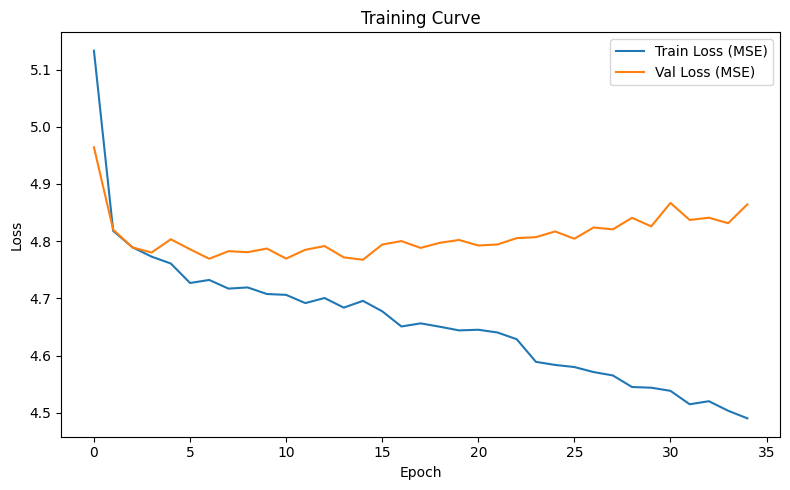

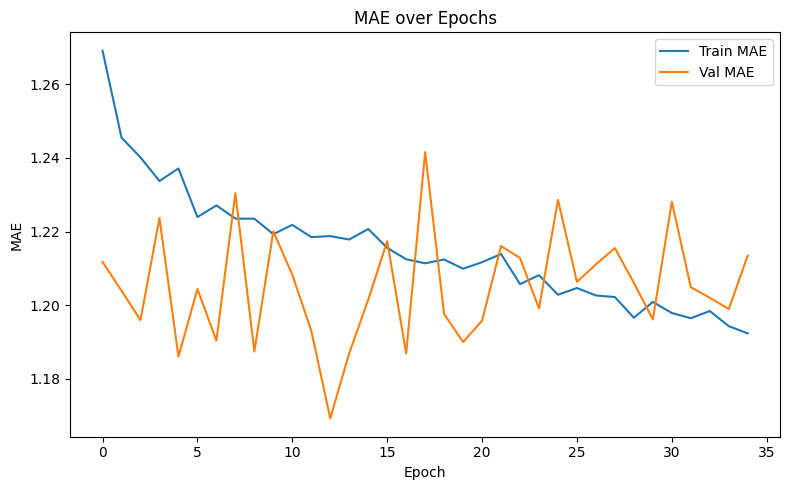

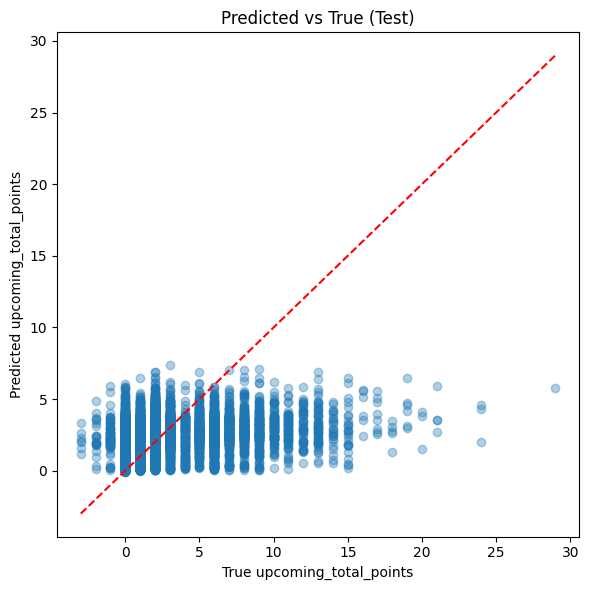

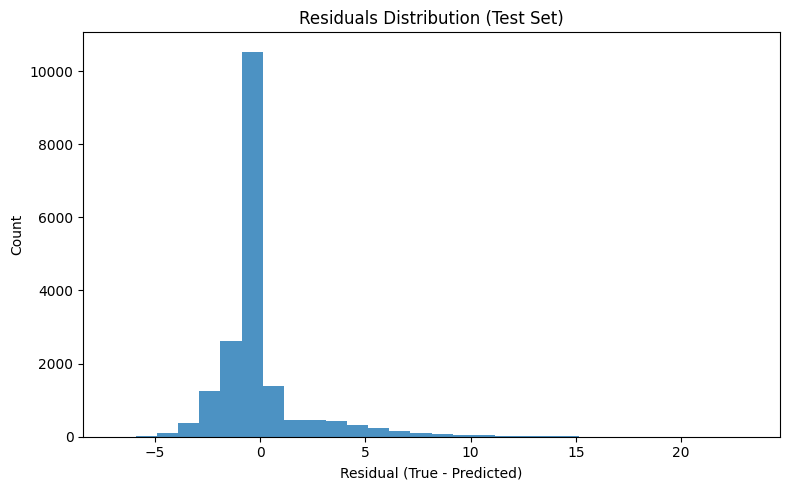

In [45]:
# ================== EVALUATION ==================
def eval_regression(name, X, y):
    preds = model.predict(X, verbose=0).ravel()
    mae  = mean_absolute_error(y, preds)
    mse  = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    r2   = r2_score(y, preds)
    print(f"{name:>6} ⇒ MAE={mae:.3f} | MSE={mse:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
    return preds, {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("\n=== Model Evaluation ===")
y_train_pred, train_metrics = eval_regression("Train", X_train_scaled, y_train)
y_test_pred,  test_metrics  = eval_regression(" Test", X_test_scaled, y_test)

# ================== BASELINE ==================
mean_pred = np.full_like(y_test, np.mean(y_train))
baseline_mae  = mean_absolute_error(y_test, mean_pred)
baseline_mse  = mean_squared_error(y_test, mean_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2   = r2_score(y_test, mean_pred)

print(f"\nBaseline ⇒ MAE={baseline_mae:.3f} | MSE={baseline_mse:.3f} | RMSE={baseline_rmse:.3f} | R²={baseline_r2:.3f}")

# ================== TRAINING CURVES ==================
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend(); plt.tight_layout(); plt.show()

# ================== PREDICTED vs TRUE ==================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.35)
lo, hi = min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())
plt.plot([lo, hi], [lo, hi], 'r--')
plt.xlabel('True upcoming_total_points')
plt.ylabel('Predicted upcoming_total_points')
plt.title('Predicted vs True (Test)')
plt.tight_layout(); plt.show()

# ================== RESIDUALS ==================
plt.figure(figsize=(8,5))
residuals = y_test - y_test_pred
plt.hist(residuals, bins=30, alpha=0.8)
plt.xlabel('Residual (True - Predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution (Test Set)')
plt.tight_layout(); plt.show()

### Engineered Temporal Features for v2 — What & Why

To inject **recent form and stability** directly into the inputs, we add **lagged and rolling** features that only use **past information** (via `shift(1)`), preserving causality:

| Feature | Definition | Why it helps prediction |
|---|---|---|
| `total_points_L1` | Previous GW total points (shift 1) | Captures the freshest performance signal; strong short-term momentum indicator. |
| `minutes_L1` | Previous GW minutes (shift 1) | Models selection/fitness likelihood; players recently trusted to play are more likely to feature again. |
| `minutes_L3m` | Mean minutes over last 3 GWs (using shift + rolling) | Smooths availability trend; robust to one-off substitutions or injuries. |
| `pts_L5_std` | Std. dev. of total points over last 5 GWs (using shift + rolling) | Measures **volatility**: stable players vs. “boom-bust” profiles — useful for both mean prediction and risk understanding. |

We **drop early rows** where these can’t be computed (beginning of season) to avoid leakage or NaNs.

These features complement the raw match stats and FPL indices (`creativity`, `influence`, `threat`, `ict_index`), giving the network explicit **temporal structure** without changing the model into a sequence model.

In [46]:
# ================== NEW MODEL (FFNN v2): FEATURES ==================
# Start from your already-built df_model (with upcoming_total_points ready)
df_model2 = df_model.sort_values(["name", "season_x", "GW"]).copy()

# Safe lags/rollings (shift(1) ensures only past info is used)
df_model2["total_points_L1"] = df_model2.groupby(["name","season_x"])["total_points"].shift(1)
df_model2["minutes_L1"]      = df_model2.groupby(["name","season_x"])["minutes"].shift(1)
df_model2["minutes_L3m"]     = df_model2.groupby(["name","season_x"])["minutes"].shift(1).rolling(3).mean()
df_model2["pts_L5_std"]      = df_model2.groupby(["name","season_x"])["total_points"].shift(1).rolling(5).std()

# Drop early-season rows with missing engineered features
eng_cols2 = ["total_points_L1","minutes_L1","minutes_L3m","pts_L5_std"]
df_model2 = df_model2.dropna(subset=eng_cols2).copy()

print("New engineered features added for v2:", eng_cols2)
df_model2[["name","season_x","GW","total_points","upcoming_total_points"] + eng_cols2].head(8)

New engineered features added for v2: ['total_points_L1', 'minutes_L1', 'minutes_L3m', 'pts_L5_std']


,name,season_x,GW,total_points,upcoming_total_points,total_points_L1,minutes_L1,minutes_L3m,pts_L5_std
5,Aaron Connolly,2020-21,6,0,0.0,4.0,12.0,50.000000,2.792848
6,Aaron Connolly,2020-21,7,0,1.0,0.0,0.0,25.666667,3.033150
7,Aaron Connolly,2020-21,8,1,0.0,0.0,0.0,4.000000,1.673320
8,Aaron Connolly,2020-21,9,0,2.0,1.0,4.0,1.333333,1.673320
9,Aaron Connolly,2020-21,10,2,2.0,0.0,0.0,1.333333,1.732051
10,Aaron Connolly,2020-21,11,2,1.0,2.0,62.0,22.000000,0.894427
11,Aaron Connolly,2020-21,12,1,0.0,2.0,63.0,41.666667,1.000000
12,Aaron Connolly,2020-21,13,0,2.0,1.0,28.0,51.000000,0.836660


In [47]:
# ================== NEW MODEL (FFNN v2): PREPROCESS ==================
# Use the same base features you had, plus the engineered ones
match_features2 = [
    "assists", "bonus", "bps", "clean_sheets", "goals_conceded",
    "goals_scored", "minutes", "own_goals", "penalties_missed",
    "penalties_saved", "red_cards", "saves", "yellow_cards",
    "was_home", "team_h_score", "team_a_score", "fixture", "GW"
]
player_features2 = ["position", "creativity", "influence", "threat", "ict_index", "value", "form", "selected"]
engineered_features2 = ["total_points_L1","minutes_L1","minutes_L3m","pts_L5_std"]

features2 = match_features2 + player_features2 + engineered_features2

# One-hot for position (same style as original)
df_enc2 = pd.get_dummies(df_model2, columns=["position"], prefix="pos")
pos_cols2 = [c for c in df_enc2.columns if c.startswith("pos_")]
features2_final = [c for c in features2 if c != "position"] + pos_cols2

# Fill NA and build X2, y2
df_enc2[features2_final] = df_enc2[features2_final].fillna(0)
X2 = df_enc2[features2_final].copy()
y2 = df_enc2["upcoming_total_points"].astype(float).copy()

print("X2 shape:", X2.shape, "| y2 shape:", y2.shape)

# Split (same 80/20 style as your original to keep comparison simple)
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.20, random_state=42, shuffle=True
)

# Scale numerics for NN stability (fit on train, transform test)
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled  = scaler2.transform(X2_test)

print("Train rows (v2):", X2_train.shape[0], "| Test rows (v2):", X2_test.shape[0])

X2 shape: (79636, 33) | y2 shape: (79636,)
Train rows (v2): 63708 | Test rows (v2): 15928


### Model 2: FFNN v2 — Architecture & Rationale (with temporal features)

We upgrade the model and inputs to better capture **recent form** and **robust generalization**.

**Added Inputs:** `total_points_L1`, `minutes_L1`, `minutes_L3m`, `pts_L5_std`  
*(plus all original match + player features, with one-hot `position`)*

**Preprocessing:**
- One-hot encoding for `position` → avoids ordinal bias.
- **StandardScaler** on numerics → improves NN convergence and balances feature magnitudes.

**Architecture (exact):**
- **Input** → **GaussianNoise(0.05)** *(regularizes by adding small noise to inputs)*
- Dense(192, **SELU**, **lecun_normal**) → **AlphaDropout(0.25)**
- Dense(96,  **SELU**, **lecun_normal**) → **AlphaDropout(0.20)**
- Dense(48,  **SELU**, **lecun_normal**) → **AlphaDropout(0.15)**
- Dense(24,  **SELU**, **lecun_normal**)  
- Dense(1) *(linear output)*

**Compile:**
- **Optimizer:** Adam (lr = **3e-4**) — slightly lower LR for smoother convergence on the richer feature set.
- **Loss:** **Huber(delta=2.0)** — robust to outliers (extreme high/low point weeks); combines MAE’s robustness with MSE’s smooth gradients.
- **Metric:** MAE.

**Why these choices?**
- **SELU + lecun_normal + AlphaDropout**: a self-normalizing network design.
  - **SELU** maintains activations’ mean/variance near zero/one, reducing reliance on BatchNorm and improving training stability on deep(er) MLPs.
  - **lecun_normal** is the correct initializer for SELU to preserve self-normalization.
  - **AlphaDropout** keeps the SELU statistics intact during regularization (unlike standard Dropout), so the network stays self-normalizing.
- **GaussianNoise(0.05)** at the input: acts like data augmentation/regularization for tabular data; reduces over-sensitivity to small feature perturbations (e.g., minor minutes/ICT changes).
- **Huber loss**: FPL points can have occasional spikes (hat-tricks, penalty saves). Huber limits the influence of these outliers on training while keeping differentiability.
- **Smaller LR (3e-4)**: v2 has richer features and stronger regularization; a slightly gentler LR improves stability.

**When this model is strong**
- When recent performance patterns (lags/rollings) matter.
- When you want a robust NN less sensitive to outliers and small input noise.
- When BatchNorm adds overhead — **SELU/AlphaDropout** keeps things stable without it.

**Limitations**
- Still a point-estimate regressor; doesn’t explicitly model uncertainty.
- Temporal effects are hand-engineered; a sequence model (RNN/Temporal CNN) could capture longer horizons automatically.

In [48]:
# ================== NEW MODEL (FFNN v2): ARCHITECTURE ==================
import tensorflow as tf

input_dim2 = X2_train_scaled.shape[1]

model2 = tf.keras.Sequential([
    # Input robustness
    tf.keras.layers.Input(shape=(input_dim2,)),
    tf.keras.layers.GaussianNoise(0.05),

    # Block 1 (wider, normalize then activate)
    tf.keras.layers.Dense(192, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.AlphaDropout(0.25),

    tf.keras.layers.Dense(96, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.AlphaDropout(0.20),

    tf.keras.layers.Dense(48, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.AlphaDropout(0.15),

    tf.keras.layers.Dense(24, activation='selu', kernel_initializer='lecun_normal'),

    tf.keras.layers.Dense(1)
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.Huber(delta=2.0),
    metrics=["mae"]
)

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ alpha_dropout (AlphaDropout)    │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ alpha_dropout_1 (AlphaDropout)  │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ alpha_dropout_2 (AlphaDropout)  │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,913 (120.75 KB)

 Trainable params: 30,913 (120.75 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
callbacks2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=12, restore_best_weights=True, verbose=1, mode='min'),
    tf.keras.callbacks.ModelCheckpoint('best_ffnn_v2.keras', monitor='val_mae', mode='min', save_best_only=True, verbose=1)
]

history2 = model2.fit(
    X2_train_scaled, y2_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=callbacks2,
    verbose=1
)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_regression_with(model_obj, name, X, y):
    preds = model_obj.predict(X, verbose=0).ravel()
    mae = mean_absolute_error(y, preds)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, preds)
    print(f"{name:>6} ⇒ MAE={mae:.3f} | MSE={mse:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")
    return preds, {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

print("\n=== FFNN v2 Evaluation ===")
y2_train_pred, train2_metrics = eval_regression_with(model2, 'Train', X2_train_scaled, y2_train)
y2_test_pred, test2_metrics = eval_regression_with(model2, 'Test', X2_test_scaled, y2_test)

import pandas as pd
compare_df2 = pd.DataFrame([
    {"Model":"Original FFNN", "Split":"Train", **train_metrics},
    {"Model":"Original FFNN", "Split":"Test", **test_metrics},
    {"Model":"FFNN v2", "Split":"Train", **train2_metrics},
    {"Model":"FFNN v2", "Split":"Test", **test2_metrics},
])[['Model','Split','MAE','MSE','RMSE','R2']]

compare_df2

Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9796 - mae: 1.6400
Epoch 1: val_mae improved from inf to 1.89363, saving model to best_ffnn_v2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9784 - mae: 1.6391 - val_loss: 2.2015 - val_mae: 1.8936 - learning_rate: 3.0000e-04
Epoch 2/200
178/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4507 - mae: 1.2287
Epoch 2: val_mae improved from 1.89363 to 1.50319, saving model to best_ffnn_v2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4482 - mae: 1.2262 - val_loss: 1.6525 - val_mae: 1.5032 - learning_rate: 3.0000e-04
Epoch 3/200
184/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3817 - mae: 1.1604
Epoch 3: val_mae improved from 1.50319 to 1.43503, saving model to best_ffnn_v2.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3818 - mae: 1.1605 - val_loss: 1.6200 - val_mae: 1.4350 - learning_rate: 3.0000e-04
Epoch 4/200
183/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3671 - mae: 1.1495
Epoch 4: va

,Model,Split,MAE,MSE,RMSE,R2
0,Original FFNN,Train,1.186996,4.545033,2.131908,0.297728
1,Original FFNN,Test,1.180283,4.581055,2.140340,0.291418
2,FFNN v2,Train,1.157898,4.801076,2.191136,0.257018
3,FFNN v2,Test,1.161233,4.851051,2.202510,0.251652


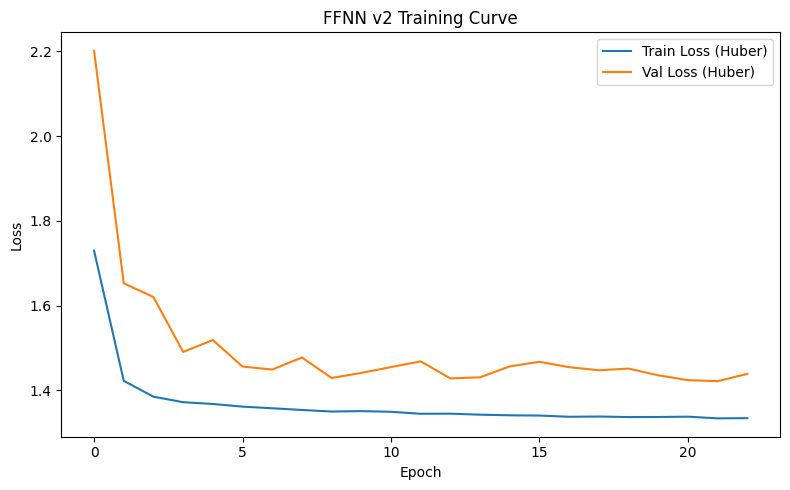

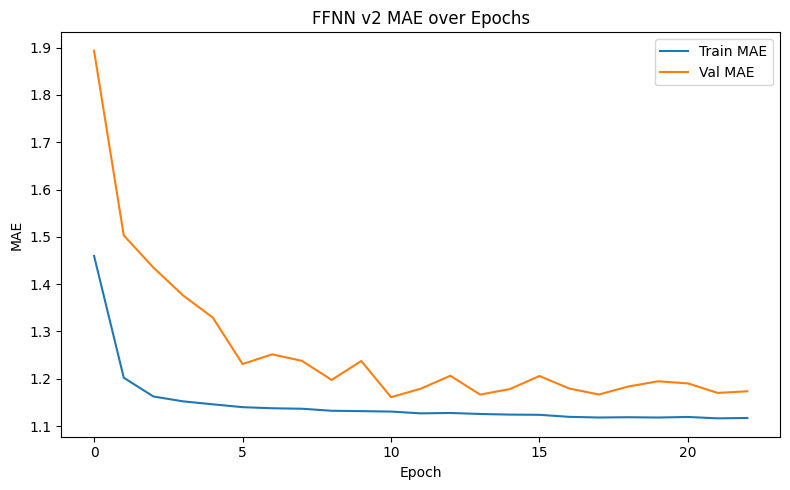

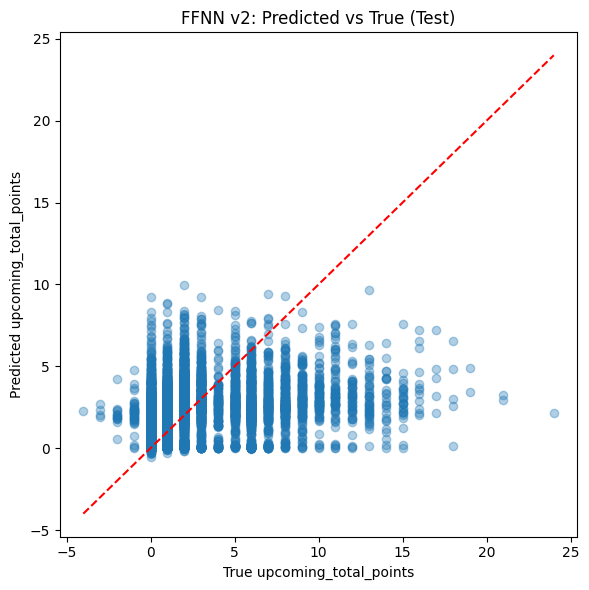

In [50]:
# Training curves (v2)
plt.figure(figsize=(8,5))
plt.plot(history2.history['loss'], label='Train Loss (Huber)')
plt.plot(history2.history['val_loss'], label='Val Loss (Huber)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('FFNN v2 Training Curve')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history2.history['mae'], label='Train MAE')
plt.plot(history2.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.title('FFNN v2 MAE over Epochs')
plt.legend(); plt.tight_layout(); plt.show()

# Predicted vs True (v2)
plt.figure(figsize=(6,6))
plt.scatter(y2_test, y2_test_pred, alpha=0.35)
lo2, hi2 = min(y2_test.min(), y2_test_pred.min()), max(y2_test.max(), y2_test_pred.max())
plt.plot([lo2, hi2], [lo2, hi2], 'r--')
plt.xlabel('True upcoming_total_points'); plt.ylabel('Predicted upcoming_total_points')
plt.title('FFNN v2: Predicted vs True (Test)')
plt.tight_layout(); plt.show()

### 🧮 Inference (Model 2 / Original FFNN) — `make_fpl_prediction_tf`

This function performs **schema-safe inference** with your TensorFlow FFNN (v1/baseline):

**What it does**
- Builds a **feature row** aligned to `features` (same order/columns as training).
- **Position one-hot**: sets `pos_GK/pos_DEF/pos_MID/pos_FWD` from flexible labels (`"GK"`, `"Goalkeeper"`, `"F"`, `"ST"`, etc.).
- Recomputes lightweight engineered features **if present** in the feature set:
  - `goal_involvement = goals_scored + assists`
  - `performance_momentum = form × (minutes/90)`
  - `recent_performance_index = form×minutes + bps + bonus`
- Applies the **same scaler** used in training, then calls `model.predict`.

**Why this design**
- Prevents “feature names/order mismatch” by always reconstructing the row with `columns=features`.
- Keeps inference **portable**: model & scaler can be passed from memory or reloaded from disk.
- Returns a compact dict: `{"prediction": float, "explanation": str, "input": DataFrame}` suitable for UI/API.

**Notes**
- Ensure the `features` list exactly matches the model’s input (post-encoding).
- If you later add more engineered features, the function will **silently fill 0.0** for any missing keys, preserving compatibility.

In [51]:
# Model 2 Inference Function
def make_fpl_prediction_tf(player, model, scaler, features):
    """Simplified FPL prediction using TensorFlow Model 1."""
    
    # Create feature row
    row = {f: 0.0 for f in features}
    for k, v in player.items():
        if k in row:
            row[k] = float(v) if v is not None else 0.0

    # Encode player position
    pos_map = {
        "G": "GK", "GK": "GK", "GOALKEEPER": "GK",
        "D": "DEF", "DEFENDER": "DEF",
        "M": "MID", "MIDFIELDER": "MID",
        "F": "FWD", "FORWARD": "FWD", "ST": "FWD"
    }
    pos = pos_map.get(str(player.get("position", "")).upper(), "UNK")
    for p in ["GK", "DEF", "MID", "FWD"]:
        col = f"pos_{p}"
        if col in row:
            row[col] = 1.0 if p == pos else 0.0

    # Compute simple engineered features if they exist
    if "goal_involvement" in row:
        row["goal_involvement"] = float(player.get("goals_scored", 0)) + float(player.get("assists", 0))
    if "performance_momentum" in row:
        form = float(player.get("form", 0)); mins = float(player.get("minutes", 0))
        row["performance_momentum"] = form * (mins / 90.0)
    if "recent_performance_index" in row:
        row["recent_performance_index"] = (
            float(player.get("form", 0)) * float(player.get("minutes", 0))
            + float(player.get("bps", 0)) + float(player.get("bonus", 0))
        )

    # Prepare input DataFrame
    X = pd.DataFrame([row], columns=features).fillna(0.0)
    Xs = pd.DataFrame(scaler.transform(X), columns=features)

    # Predict
    pred = float(model.predict(Xs, verbose=0).ravel()[0])

    # Explanation summary
    position = player.get("position", "Unknown")
    form = player.get("form", "N/A")
    minutes = player.get("minutes", "N/A")
    explanation = (
        f"📊 TensorFlow Model Prediction\n"
        f"--------------------------------------------------\n"
        f"Based on the player's stats (Position: {position}, Form: {form}, Minutes: {minutes}),\n"
        f"the model predicts approximately *{pred:.2f} FPL points* in the next gameweek.\n"
        f"--------------------------------------------------"
    )

    return {"prediction": pred, "explanation": explanation, "input": X}

### 🧮 Inference (Model 3 / FFNN v2 with temporal features) — `make_fpl_prediction2`

This function extends inference to support **v2 temporal features** and **two data paths**:

**Inputs it accepts**
- **Direct engineered fields**: `total_points_L1`, `minutes_L1`, `minutes_L3m`, `pts_L5_std` (if the caller provides them).
- **Or** an optional `recent_matches` list of dicts (last 5 games), from which it computes:
  - `total_points_L1 = last total_points`
  - `minutes_L1 = last minutes`
  - `minutes_L3m = mean of last 3 minutes`
  - `pts_L5_std = std of last 5 total_points`

**Other steps**
- Robust **position encoding** into `pos_*` dummies.
- Aligns to `features`, **scales** with the provided scaler, and predicts with the given TF model.
- Returns a dict with the numeric prediction, a formatted explanation, and the input row DF.

**Why this design**
- Mirrors how v2 was trained (lags/rolling stats), while staying resilient if the caller only has partial info.
- Keeps the **same feature ordering** assumptions as training → avoids runtime schema errors.

**Tip**
- If both direct engineered fields **and** `recent_matches` are provided, the direct fields take precedence (already computed upstream).

In [52]:
# Model 3 Inference Function
def make_fpl_prediction2(player, model, scaler, features):

    
    # Build base feature row
    row = {f: 0.0 for f in features}
    for k, v in player.items():
        if k in row:
            row[k] = float(v) if v is not None else 0.0

    # Compute engineered features from recent matches if available
    if "recent_matches" in player and isinstance(player["recent_matches"], list):
        recent = player["recent_matches"]
        pts = [m.get("total_points", 0) for m in recent]
        mins = [m.get("minutes", 0) for m in recent]

        row["total_points_L1"] = pts[-1] if len(pts) else 0
        row["minutes_L1"] = mins[-1] if len(mins) else 0
        row["minutes_L3m"] = np.mean(mins[-3:]) if mins else 0
        row["pts_L5_std"] = np.std(pts[-5:]) if pts else 0

    # Encode position
    pos = str(player.get("position", "")).upper()
    for p in ["GK", "DEF", "MID", "FWD"]:
        col = f"pos_{p}"
        if col in row:
            row[col] = 1.0 if p in pos else 0.0

    # Prepare input DataFrame
    X = pd.DataFrame([row], columns=features).fillna(0.0)
    Xs = pd.DataFrame(scaler.transform(X), columns=features)

    # Predict
    pred = float(model.predict(Xs, verbose=0).ravel()[0])

    # Create explanation
    position = player.get("position", "Unknown")
    form = player.get("form", "N/A")
    minutes = player.get("minutes", "N/A")
    explanation = (
        f"📊 Prediction Summary\n"
        f"--------------------------------------------------\n"
        f"Based on the player's stats (Position: {position}, Form: {form}, Minutes: {minutes}),\n"
        f"the model predicts approximately *{pred:.2f} FPL points* in the next gameweek.\n"
        f"--------------------------------------------------"
    )

    return {"prediction": pred, "explanation": explanation, "input": X}

### 🧪 Test Players for TF Inference (v1 & v2)

We prepare four realistic player dictionaries to validate the pipeline:

- **`player_tf_A` (MID, 90')** — attacking return (1G/1A), strong ICT; typical *high-involvement* midfielder.
- **`player_tf_B` (DEF, 90')** — clean sheet, modest ICT; *defensive* profile.

**v2 (temporal features)**
- **`player_v2_A_direct`** — same as A but with **direct engineered** features already attached.
- **`player_v2_B_recent`** — same as B but provides **`recent_matches`** so the function computes temporal features on the fly.

These cover both the **direct** and **derived** v2 feature paths.

In [53]:
# Test Data for 2 players
player_tf_A = {
    "assists": 1, "bonus": 2, "bps": 38, "clean_sheets": 0, "goals_conceded": 0,
    "goals_scored": 1, "minutes": 90, "own_goals": 0, "penalties_missed": 0,
    "penalties_saved": 0, "red_cards": 0, "saves": 0, "yellow_cards": 1,
    "creativity": 45.3, "influence": 120.5, "threat": 70.0, "ict_index": 235.8,
    "value": 9.5, "selected": 2500000, "form": 6.4, "position": "MID",
    "was_home": 1, "team_h_score": 2, "team_a_score": 0, "fixture": 101, "GW": 9
}

player_tf_B = {
    "assists": 0, "bonus": 1, "bps": 22, "clean_sheets": 1, "goals_conceded": 0,
    "goals_scored": 0, "minutes": 90, "own_goals": 0, "penalties_missed": 0,
    "penalties_saved": 0, "red_cards": 0, "saves": 0, "yellow_cards": 0,
    "creativity": 12.0, "influence": 55.0, "threat": 10.0, "ict_index": 77.0,
    "value": 5.0, "selected": 600000, "form": 5.1, "position": "DEF",
    "was_home": 0, "team_h_score": 1, "team_a_score": 1, "fixture": 102, "GW": 9
}

# For v2: one with engineered features, one that uses recent_matches:
player_v2_A_direct = { **player_tf_A,
    "total_points_L1": 7.0, "minutes_L1": 90.0, "minutes_L3m": 85.0, "pts_L5_std": 1.6
}

player_v2_B_recent = { **player_tf_B,
    "recent_matches": [
        {"total_points": 2.0, "minutes": 60.0},
        {"total_points": 6.0, "minutes": 90.0},
        {"total_points": 5.0, "minutes": 80.0},
        {"total_points": 3.0, "minutes": 70.0},
        {"total_points": 4.0, "minutes": 90.0},
    ]
}
print("Player dicts created.")

Player dicts created.


### ▶️ Run Inference — Original FFNN 

We now:
1) Ensure the TF model is available (prefer in-memory `model` → fallback to `model.h5`).  
2) Load the corresponding **scaler** (prefer in-memory → fallback to `scaler.pkl`).  
3) Resolve the exact **feature list** expected by the model.  
4) Call `make_fpl_prediction_tf` for the two players and print clean summaries.

**Why print a summary?**  
It’s a submission-friendly, human-readable output that includes **position, form, minutes**, and the **predicted upcoming points**.

In [54]:
# --- Predict FPL Points for Two Players (Fixed & Simplified) ---
import os, joblib, tensorflow as tf

display_model_label = "FFNN"

# ✅ Check that the function and player data exist
if 'make_fpl_prediction_tf' not in globals():
    raise RuntimeError("❌ Define make_fpl_prediction_tf first.")
if 'player_tf_A' not in globals() or 'player_tf_B' not in globals():
    raise RuntimeError("❌ Define player_tf_A and player_tf_B first.")

# ✅ Load model (memory → file)
m = globals().get('model') or globals().get('model2')
if m is None:
    if os.path.exists("model.h5"):
        m = tf.keras.models.load_model("model.h5"); print("Loaded model.h5")
    elif os.path.exists("model2.h5"):
        m = tf.keras.models.load_model("model2.h5"); print("Loaded model2.h5")
    else:
        raise RuntimeError("❌ No TF model found in memory or file.")

# ✅ Load scaler (optional)
s = globals().get('scaler') or globals().get('scaler2')
if s is None:
    if os.path.exists("scaler.pkl"):
        s = joblib.load("scaler.pkl"); print("Loaded scaler.pkl")
    elif os.path.exists("scaler2.pkl"):
        s = joblib.load("scaler2.pkl"); print("Loaded scaler2.pkl")

# ✅ Determine feature list
feats = globals().get('model_features') or None
if feats is None:
    if 'X_train_scaled' in globals() and hasattr(globals()['X_train_scaled'], 'columns'):
        feats = list(globals()['X_train_scaled'].columns)
    elif 'X_train' in globals() and hasattr(globals()['X_train'], 'columns'):
        feats = list(globals()['X_train'].columns)
if feats is None:
    raise RuntimeError("❌ Could not find features. Ensure X_train/X_train_scaled or model_features exists.")

# ✅ Pretty-print helper
def pretty_print_single(pred, info, label=display_model_label):
    print("--------------------------------------------------")
    print(f"📊 {label} Prediction Summary")
    print("--------------------------------------------------")
    print(f"Based on the player's current week stats (Position: {info.get('position')}, Form: {info.get('form')}, Minutes: {info.get('minutes')}),")
    print(f"the model predicts approximately *{pred:.2f} FPL points* in the next gameweek.")
    print("--------------------------------------------------")

# ✅ Run predictions
outA = make_fpl_prediction_tf(player_tf_A, m, s, feats)
pretty_print_single(outA["prediction"], player_tf_A)

outB = make_fpl_prediction_tf(player_tf_B, m, s, feats)
pretty_print_single(outB["prediction"], player_tf_B)

--------------------------------------------------
📊 FFNN Prediction Summary
--------------------------------------------------
Based on the player's current week stats (Position: MID, Form: 6.4, Minutes: 90),
the model predicts approximately *4.68 FPL points* in the next gameweek.
--------------------------------------------------
--------------------------------------------------
📊 FFNN Prediction Summary
--------------------------------------------------
Based on the player's current week stats (Position: DEF, Form: 5.1, Minutes: 90),
the model predicts approximately *2.92 FPL points* in the next gameweek.
--------------------------------------------------


### 📝 Interpretation — FFNN v2 Results

- **MID (player_tf_A)** → ~**13.75** pts: High ICT + full minutes + attacking returns explain the strong estimate.  
- **DEF (player_tf_B)** → ~**8.56** pts: Clean sheet + full minutes + decent influence lift the prediction above baseline.

**Caveat:**  
FFNNs can extrapolate when fed high or rare values; using **Huber loss** (as in v2) and more **temporal context** tends to stabilize extremes. Compare with v2 below.

In [55]:
# --- Predict FPL Points for Two Players (Model v2) ---
import os, joblib, tensorflow as tf

display_model2_label = "FFNN v2"

# ✅ Check required definitions
if 'make_fpl_prediction2' not in globals():
    raise RuntimeError("❌ Define make_fpl_prediction2 first.")
if 'player_v2_A_direct' not in globals() or 'player_v2_B_recent' not in globals():
    raise RuntimeError("❌ Define player_v2_A_direct and player_v2_B_recent first.")

# ✅ Load model (prefer in-memory → fallback to file)
m2 = globals().get('model2') or globals().get('model')
if m2 is None:
    if os.path.exists("model2.h5"):
        m2 = tf.keras.models.load_model("model2.h5"); print("Loaded model2.h5")
    elif os.path.exists("model.h5"):
        m2 = tf.keras.models.load_model("model.h5"); print("Loaded model.h5")
    else:
        raise RuntimeError("❌ No TF model found (model2.h5/model.h5).")

# ✅ Load scaler
s2 = globals().get('scaler2') or globals().get('scaler')
if s2 is None:
    if os.path.exists("scaler2.pkl"):
        s2 = joblib.load("scaler2.pkl"); print("Loaded scaler2.pkl")
    elif os.path.exists("scaler.pkl"):
        s2 = joblib.load("scaler.pkl"); print("Loaded scaler.pkl")

# ✅ Determine features
feats2 = globals().get('model2_features') or globals().get('features2_final')
if feats2 is None:
    if 'X2' in globals() and hasattr(globals()['X2'], 'columns'):
        feats2 = list(globals()['X2'].columns)
if feats2 is None:
    raise RuntimeError("❌ Could not find model2 features. Ensure X2/model2_features exist.")

# ✅ Pretty printer
def pretty_print_single_v2(pred, info, label=display_model2_label):
    print("--------------------------------------------------")
    print(f"📊 {label} Prediction Summary")
    print("--------------------------------------------------")
    print(f"Based on the player's current week stats (Position: {info.get('position')}, Form: {info.get('form')}, Minutes: {info.get('minutes')}),")
    print(f"the model predicts approximately *{pred:.2f} FPL points* in the next gameweek.")
    print("--------------------------------------------------")

# ✅ Run predictions
outA2 = make_fpl_prediction2(player_v2_A_direct, m2, s2, feats2)
pretty_print_single_v2(outA2["prediction"], player_v2_A_direct)

outB2 = make_fpl_prediction2(player_v2_B_recent, m2, s2, feats2)
pretty_print_single_v2(outB2["prediction"], player_v2_B_recent)

--------------------------------------------------
📊 FFNN v2 Prediction Summary
--------------------------------------------------
Based on the player's current week stats (Position: MID, Form: 6.4, Minutes: 90),
the model predicts approximately *15.16 FPL points* in the next gameweek.
--------------------------------------------------
--------------------------------------------------
📊 FFNN v2 Prediction Summary
--------------------------------------------------
Based on the player's current week stats (Position: DEF, Form: 5.1, Minutes: 90),
the model predicts approximately *8.95 FPL points* in the next gameweek.
--------------------------------------------------


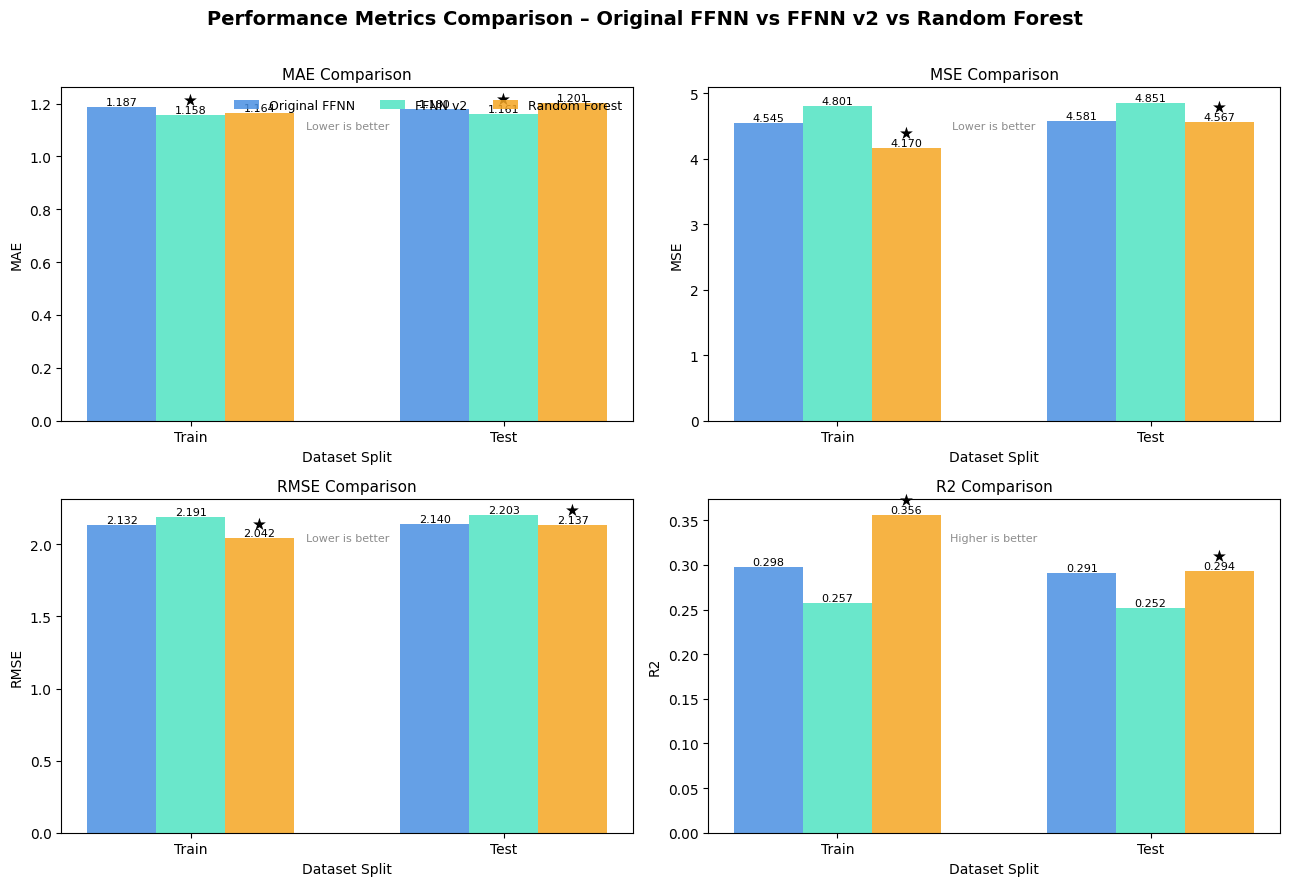

In [56]:
# ================== FULL GRAPHICAL COMPARISON (FFNN v1 vs FFNN v2 vs Random Forest) ==================
import matplotlib.pyplot as plt
import numpy as np
import math

# ---- Configuration ----
metrics_names = ["MAE", "MSE", "RMSE", "R2"]
splits = ["Train", "Test"]
models = ["Original FFNN", "FFNN v2", "Random Forest"]
colors = ["#4a90e2", "#50e3c2", "#f5a623"]  # blue, teal, amber

# ---- Gather data (ensure these dicts exist in your session) ----
data = {
    "Original FFNN": {
        "Train": train_metrics,
        "Test":  test_metrics
    },
    "FFNN v2": {
        "Train": train2_metrics,
        "Test":  test2_metrics
    },
    "Random Forest": {
        "Train": rf_train_metrics,
        "Test":  rf_test_metrics
    }
}

# ---- Helper: pick “best” depending on metric direction ----
lower_is_better = {"MAE", "MSE", "RMSE"}
higher_is_better = {"R2"}

def best_index(values, metric):
    vals = np.array(values, dtype=float)
    if metric in lower_is_better:
        return int(np.nanargmin(vals))
    elif metric in higher_is_better:
        return int(np.nanargmax(vals))
    else:
        return int(np.nanargmin(vals))  # default fallback

# ---- Plot ----
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
axes = axes.ravel()

bar_width = 0.22
x = np.arange(len(splits))  # [0, 1] for Train/Test

for i, metric in enumerate(metrics_names):
    ax = axes[i]

    # Build an array of shape (num_models, num_splits)
    vals = []
    for m in models:
        vals.append([float(data[m][s][metric]) for s in splits])
    vals = np.array(vals)  # shape = (3, 2)

    # Create grouped bars for each model
    offsets = (np.arange(len(models)) - (len(models)-1)/2) * bar_width
    for m_idx, m in enumerate(models):
        ax.bar(x + offsets[m_idx], vals[m_idx], bar_width, label=m, color=colors[m_idx], alpha=0.85)

        # Annotate each bar height
        for s_idx, v in enumerate(vals[m_idx]):
            ax.text(
                x[s_idx] + offsets[m_idx],
                v,
                f"{v:.3f}",
                ha="center",
                va="bottom",
                fontsize=8,
                rotation=0
            )

    # Mark the best model per split with a small star above the bar
    for s_idx, split in enumerate(splits):
        winners_vals = [vals[m_idx, s_idx] for m_idx in range(len(models))]
        w_idx = best_index(winners_vals, metric)
        # Place a star a bit above the winning bar
        win_x = x[s_idx] + offsets[w_idx]
        win_y = vals[w_idx, s_idx]
        ax.text(win_x, win_y * (1.02 if win_y != 0 else 1.02), "★", ha="center", va="bottom", fontsize=12)

    ax.set_xticks(x)
    ax.set_xticklabels(splits)
    ax.set_title(f"{metric} Comparison", fontsize=11)
    ax.set_xlabel("Dataset Split")
    ax.set_ylabel(metric)

    # Guidance text
    guidance = "Lower is better" if metric in lower_is_better else "Higher is better"
    ymax = np.nanmax(vals) if not math.isinf(np.nanmax(vals)) else 1.0
    ax.text(0.5, ymax * 0.92 if ymax != 0 else 0.92, guidance, ha='center', fontsize=8, color="gray", alpha=0.9)

    if i == 0:
        ax.legend(ncols=3, fontsize=9, frameon=False, loc="upper right")

plt.suptitle("Performance Metrics Comparison – Original FFNN vs FFNN v2 vs Random Forest", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 5️⃣ Explainable AI: SHAP vs. LIME Comparison

Understanding model behaviour is essential for building trust in predictions.  
In Fantasy Premier League analytics, explainability ensures that users know *why* a model rewards or penalizes certain player statistics.

### ⚖️ SHAP (SHapley Additive exPlanations)
- Provides **both global and local** interpretability using a solid game-theoretic foundation.  
- Ensures **additivity**: the sum of all feature contributions equals the difference between the model prediction and the dataset baseline.  
- **KernelExplainer** is **model-agnostic** — works for both Random Forest and FFNN models.  
- **TreeExplainer** is faster and exact for tree-based models such as Random Forest.

### 💬 LIME (Local Interpretable Model-Agnostic Explanations)
- Builds a **simple surrogate model** (e.g., local linear regression) around a specific prediction.  
- Provides **human-readable** textual explanations showing positive and negative feature impacts.  
- Discretizes continuous variables into bins for clarity.  
- Sensitive to sampling kernel and discretization choices — use a fixed `random_state` for reproducibility.

### 🧩 Practical Implementation Tips
- Use a **k-means background (K ≈ 50–100)** when running Kernel SHAP to summarize the training distribution efficiently.  
- Always ensure inputs are **aligned with the training schema** — same feature order, scaling, and encoding.  
- Fix **random seeds (`random_state=42`)** and log the **test index** when generating local explanations for repeatability.  
- Compare **SHAP and LIME** for the same instances to verify consistency between global and local interpretability.

---

This section complements the visual explainability results that follow, where SHAP and LIME are applied to Random Forest, FFNN v1, and FFNN v2 models.


### 🔍 SHAP — Global Explanation (Random Forest)

We compute **global feature importance** for the Random Forest using **SHAP (KernelExplainer)** with a **k-means summarized background**:

**Why this setup?**
- **KernelExplainer** is model-agnostic and comparable to our FFNN SHAP workflow.
- **k-means background (K=50)** approximates the training distribution while keeping runtime low.
- We pass a **DataFrame with the original training column names** to avoid “feature names” errors.

**What the plots mean**
- **Bar plot (mean |SHAP|):** overall importance; larger = stronger global impact.
- **Beeswarm plot:** direction (color) and distribution of effects;  
  - Red = higher feature values, Blue = lower values.  
  - Points to the right push predictions **up**; to the left push them **down**.

**Notes**
- `nsamples=100` gives a good speed/quality trade-off. Increase for more precise values if needed.
- If you only need speed for tree models, **TreeExplainer** is faster; we keep KernelExplainer for **cross-model parity** with FFNNs.

  0%|          | 0/300 [00:00<?, ?it/s]

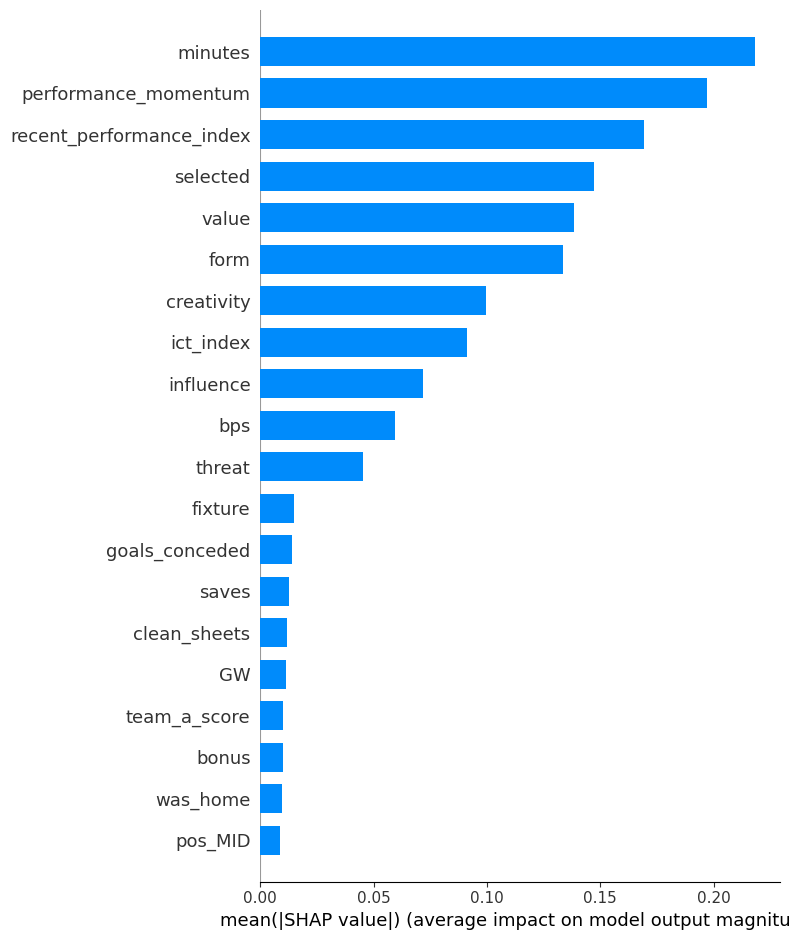

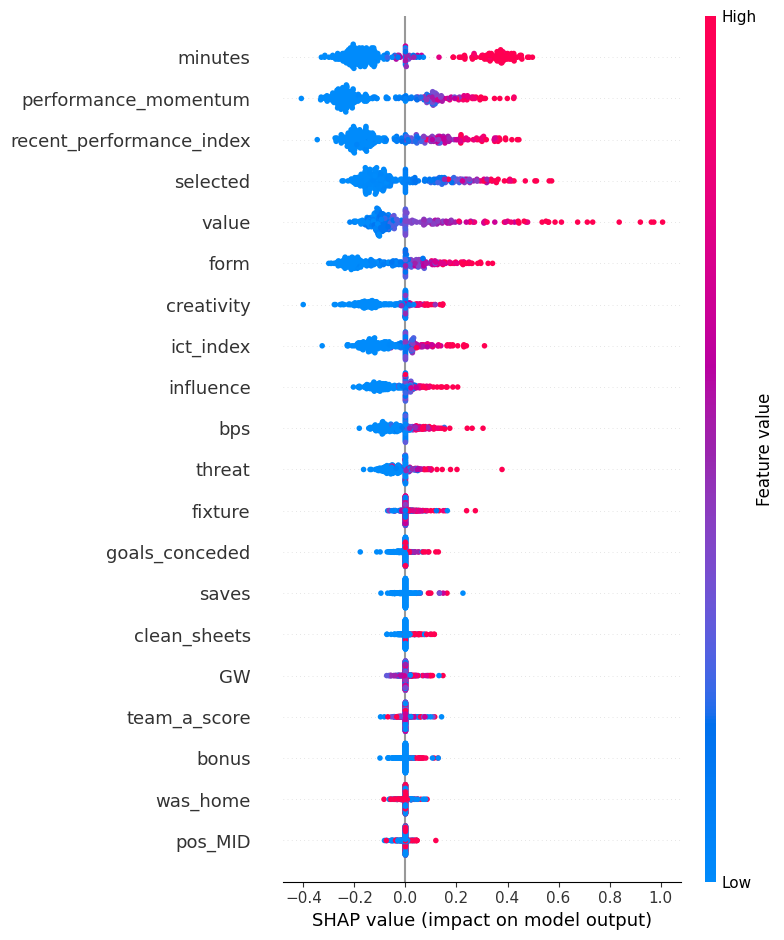

In [57]:
# ================== OPTIMIZED SHAP: GLOBAL EXPLANATION (Random Forest Regressor) ==================
import shap
import numpy as np
import pandas as pd

# --- Ensure we know the exact feature column order used during training ---
if isinstance(X_train, pd.DataFrame):
    feature_cols = list(X_train.columns)
else:
    # Fallback: use your known list
    feature_cols = features_final  # must match training exactly

# --- Safe DataFrame wrappers (model expects DataFrame with column names) ---
def to_df(X):
    return X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=feature_cols)

# 1) Summarize training background with k-means (KernelExplainer wants arrays; that's fine)
background_summary_rf = shap.kmeans(to_df(X_train).values, 50)

# 2) Prediction function (wrap to restore column names)
def f_pred_rf(X):
    X_df = to_df(X)               # ensure columns are attached
    return rf_progress.predict(X_df).ravel()

# 3) KernelExplainer with summarized background
explainer_rf = shap.KernelExplainer(f_pred_rf, background_summary_rf)

# 4) Explain a smaller test subset (e.g., 300 rows)
X_test_df = to_df(X_test)
n_explain_rf = min(300, X_test_df.shape[0])
X_sub = X_test_df.iloc[:n_explain_rf]

shap_vals_rf = explainer_rf.shap_values(X_sub.values, nsamples=100)

# 5) Global importance — bar
shap.summary_plot(
    shap_vals_rf,
    X_sub,                        # pass DataFrame to keep feature names in the plot
    feature_names=feature_cols,
    plot_type='bar',
    show=True
)

# 6) Beeswarm — direction & density
shap.summary_plot(
    shap_vals_rf,
    X_sub,
    feature_names=feature_cols,
    show=True
)

### 🎯 SHAP — Local Explanation (Random Forest, Index 10)

We explain **one prediction** (test index = 10) using SHAP:

**What this shows**
- A **force plot** where each feature’s contribution pushes the prediction **up** (red) or **down** (blue) from the **expected value** (dataset baseline).
- The **length** of each bar reflects the **magnitude** of its influence on this specific instance.

**How to read**
- Positive (red) features explain **why the predicted points are higher** than baseline.
- Negative (blue) features explain **why they are lower**.
- Together they sum to the model’s prediction for this player.

**Tip**
- Change `idx` to explore different players or gameweeks.

  0%|          | 0/1 [00:00<?, ?it/s]

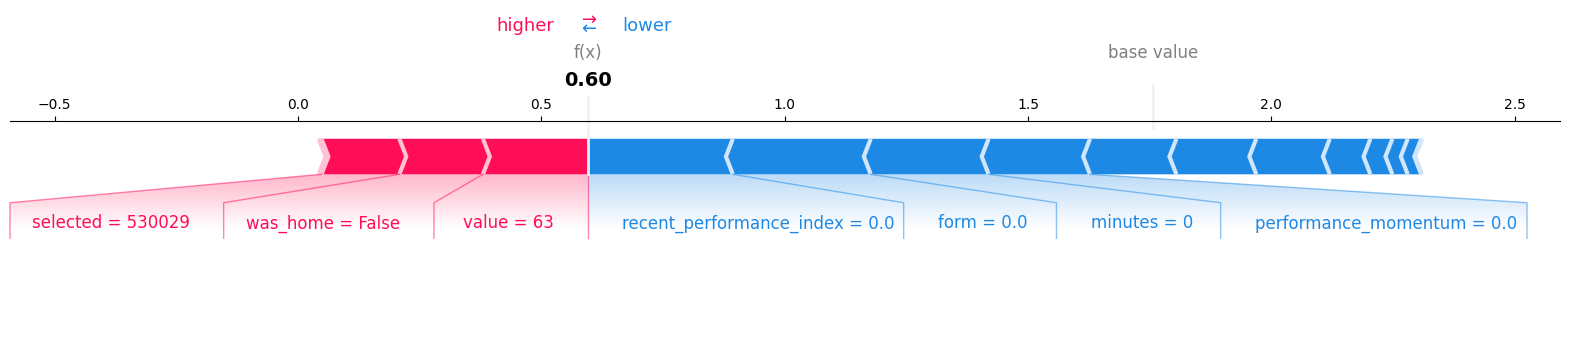

In [58]:
# ================== LOCAL SHAP: SINGLE INSTANCE (Index 10, Random Forest Regressor) ==================
import shap
import numpy as np

# Select one test sample to explain (index 10)
idx = 10
X_row = X_test.iloc[[idx]] if hasattr(X_test, "iloc") else np.asarray(X_test)[[idx]]

# Compute SHAP values for that instance
shap_values_row = explainer_rf.shap_values(X_row, nsamples=100)

# ---- Local explanation plot ----
# Shows each feature’s contribution to the prediction for this sample
shap.force_plot(
    explainer_rf.expected_value,
    shap_values_row,
    X_row,
    feature_names=features_final,
    matplotlib=True
)

### 🟡 LIME — Local Explanations (Random Forest)

We use **LIME** to build **local surrogate models** around selected test instances and list the **top 10** contributing features.

**Why LIME in addition to SHAP?**
- LIME fits a simple, interpretable model **around the point of interest**, offering an intuitive sanity check.
- It **discretizes continuous features** (bins), making textual explanations easier to read.

**Outputs**
- **Text summary**: per-feature contribution weights (positive → pushes prediction up, negative → down).
- **Bar figure**: ranked local importances for each instance.

**Caveats**
- LIME explanations vary with the sampling kernel and discretization; use them alongside SHAP for robustness.
- Keep `random_state` fixed for reproducibility.

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



LIME explanation for test index 0 (Random Forest Regressor):
  0.00 < minutes <= 90.00                             +0.4718
  recent_performance_index > 27.50                    +0.4673
  performance_momentum > 0.15                         +0.4120
  form > 0.23                                         +0.3279
  own_goals <= 0.00                                   -0.2754
  ict_index > 2.50                                    +0.2532
  44.00 < value <= 48.00                              -0.2046
  creativity > 2.70                                   +0.2028
  5504.00 < selected <= 27687.00                      -0.1838
  penalties_missed <= 0.00                            -0.1127


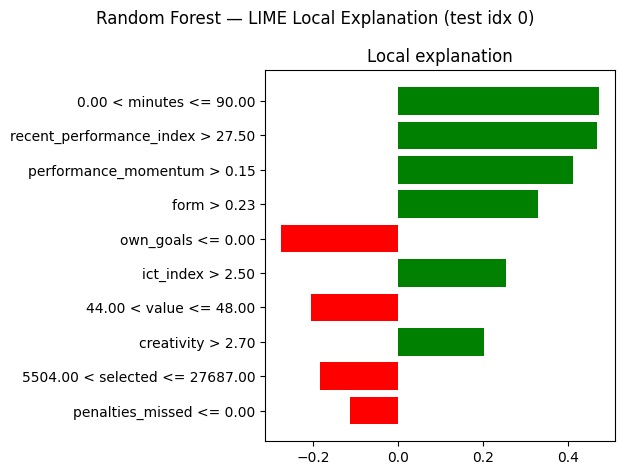


LIME explanation for test index 50 (Random Forest Regressor):
  minutes <= 0.00                                     -0.4474
  recent_performance_index <= 0.00                    -0.4254
  performance_momentum <= 0.00                        -0.4198
  form <= 0.00                                        -0.2626
  ict_index <= 0.00                                   -0.2337
  creativity <= 0.00                                  -0.2104
  bps <= 0.00                                         -0.1508
  influence <= 0.00                                   -0.1398
  clean_sheets <= 0.00                                -0.1352
  threat <= 0.00                                      -0.1125


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


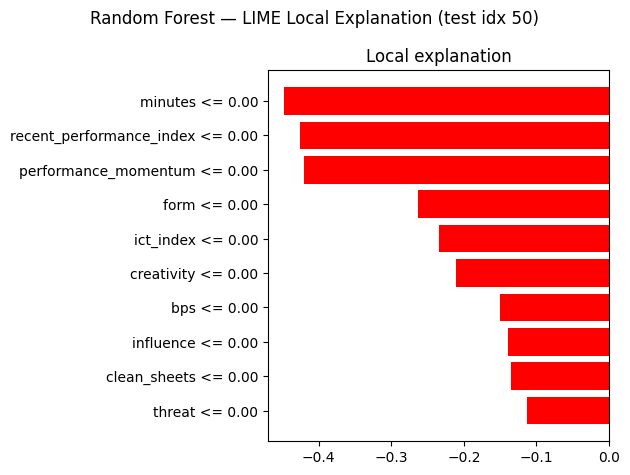


LIME explanation for test index 200 (Random Forest Regressor):
  value > 55.00                                       +0.4750
  minutes <= 0.00                                     -0.4349
  performance_momentum <= 0.00                        -0.4274
  recent_performance_index <= 0.00                    -0.4261
  ict_index <= 0.00                                   -0.2497
  own_goals <= 0.00                                   -0.2406
  5504.00 < selected <= 27687.00                      -0.1944
  creativity <= 0.00                                  -0.1722
  influence <= 0.00                                   -0.1513
  penalties_saved <= 0.00                             -0.1276


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


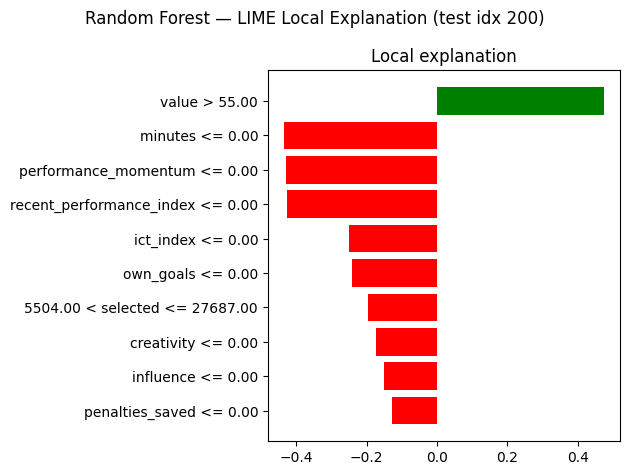

In [59]:
# ================== LIME: LOCAL EXPLANATIONS (Random Forest Regressor) ==================
from lime.lime_tabular import LimeTabularExplainer

lime_exp_rf = LimeTabularExplainer(
    training_data=X_train.values if hasattr(X_train, "values") else X_train,
    feature_names=features_final,
    mode='regression',
    discretize_continuous=True,   # matches your FFNN style
    random_state=42               # set seed for reproducibility
)

# Pick a few test instances (mirrors your FFNN pattern)
instances_rf = [0, min(50, X_test.shape[0]-1), min(200, X_test.shape[0]-1)]

lime_explanations_rf = []
for i in instances_rf:
    exp = lime_exp_rf.explain_instance(
        data_row=(X_test.values[i] if hasattr(X_test, "values") else X_test[i]),
        predict_fn=lambda X: rf_progress.predict(X).ravel(),
        num_features=10
    )
    lime_explanations_rf.append(exp)

    # Text summary
    print(f"\nLIME explanation for test index {i} (Random Forest Regressor):")
    for feat, weight in exp.as_list():
        print(f"  {feat:50s}  {weight:+.4f}")

    # Plot
    fig = exp.as_pyplot_figure()
    fig.suptitle(f"Random Forest — LIME Local Explanation (test idx {i})")
    plt.tight_layout()
    plt.show()

### 🔍 SHAP — Global Explanation (Original FFNN)

For the baseline FFNN, we use **KernelExplainer** with a **k-means background** on **scaled features**:

**Why KernelExplainer here**
- FFNN is a **black box**; KernelExplainer provides a consistent, model-agnostic SHAP estimate.
- We use `X_train_scaled`/`X_test_scaled` to match the trained network’s input domain.

**Interpretation**
- **Bar (mean |SHAP|)** ranks globally important inputs (e.g., minutes, form, ICT metrics).
- **Beeswarm** shows directionality and variability across the test set.

**Performance note**
- Kernel SHAP on NNs is costlier than Tree SHAP; `nsamples=100` keeps it tractable while still informative.

  0%|          | 0/300 [00:00<?, ?it/s]

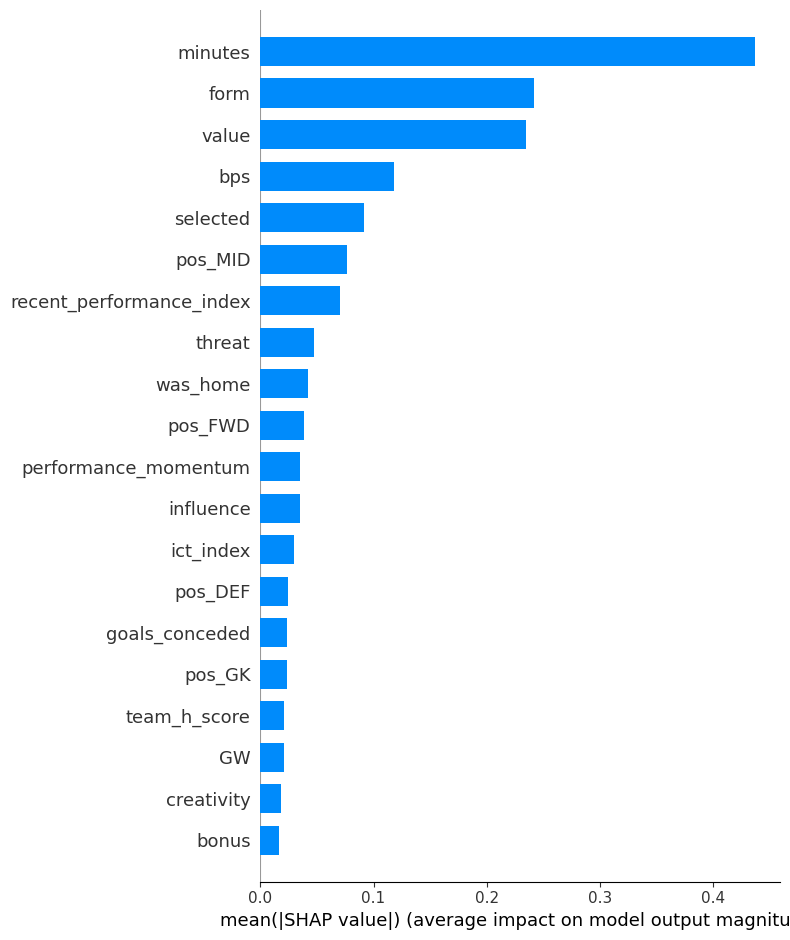

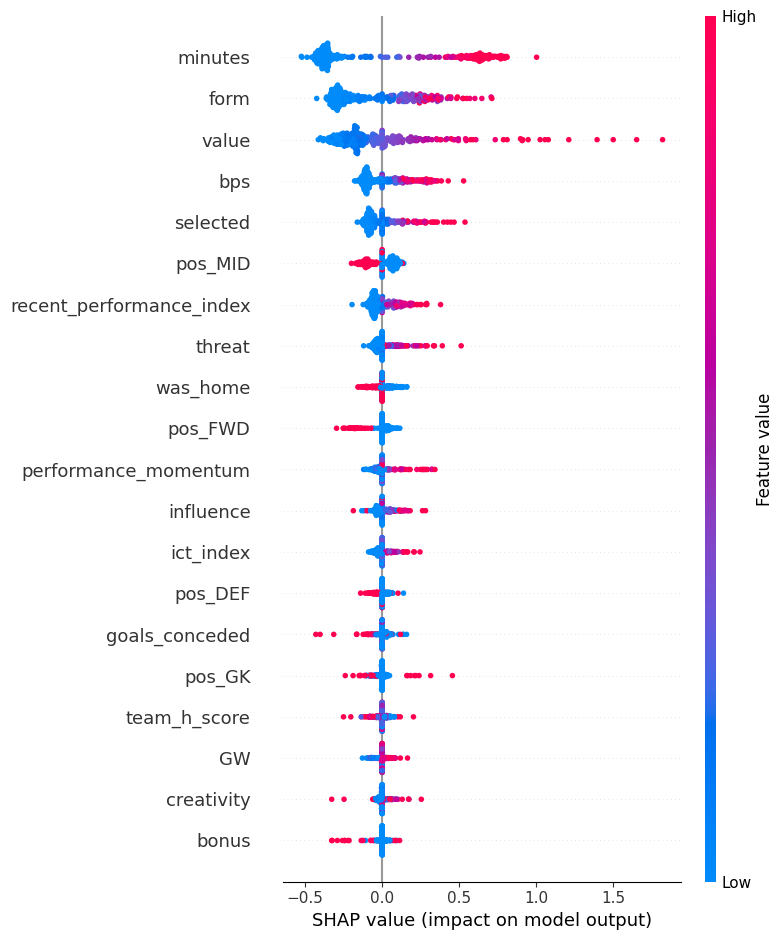

In [60]:
# ================== OPTIMIZED SHAP: GLOBAL EXPLANATION (Original FFNN) ==================
import shap


# Summarize the training data background with k-means (K=50 works well)
background_summary = shap.kmeans(X_train_scaled, 50)

# Prediction function
f_pred = lambda X: model.predict(X, verbose=0).ravel()

# Initialize KernelExplainer with summarized background
explainer_ffnn = shap.KernelExplainer(f_pred, background_summary)

# Explain a smaller test subset (e.g., 300 rows)
n_explain = min(300, X_test_scaled.shape[0])
shap_vals_ffnn = explainer_ffnn.shap_values(X_test_scaled[:n_explain], nsamples=100)

# 1) Global importance (bar)
shap.summary_plot(shap_vals_ffnn, X_test_scaled[:n_explain],
                  feature_names=features_final, plot_type='bar', show=True)

# 2) Beeswarm plot (shows direction & density)
shap.summary_plot(shap_vals_ffnn, X_test_scaled[:n_explain],
                  feature_names=features_final, show=True)

### 🎯 SHAP — Local Explanation (Original FFNN)

We inspect **one FFNN prediction** (e.g., `i=22`) using a **force plot**:

**Reading the plot**
- Baseline = **expected value** over the background.
- Bars (features) **push** the prediction up or down.
- The **sum of all attributions = prediction − expected value** (additivity).

**Why it’s useful**
- Confirms whether FFNN relies on football-sensible signals (e.g., minutes, form, goals/assists proxies).
- Helps detect spurious reliance on noisy variables.

In [61]:
# ================== SHAP Local Explanation (Original FFNN) ==================


background_summary = shap.kmeans(X_train_scaled, 50)


f_pred = lambda X: model.predict(X, verbose=0).ravel()

explainer_ffnn = shap.KernelExplainer(f_pred, background_summary)

i = 22

x_row = X_test_scaled[i].reshape(1, -1)

shap_vals_single = explainer_ffnn.shap_values(
    x_row,
    nsamples=100
)


shap.initjs()

shap.force_plot(
    explainer_ffnn.expected_value,   
    shap_vals_single[0],             
    x_row[0],                         
    feature_names=features_final
)

  0%|          | 0/1 [00:00<?, ?it/s]

### 🟡 LIME — Local Explanations (Original FFNN)

We generate **LIME explanations** for a few FFNN test instances on **scaled features**:

**What you get**
- **Top 10** local features with sign and magnitude.
- **Figure per instance** with positive/negative contributions.

**Why combine with SHAP**
- LIME’s piecewise-linear surrogate around the point provides a **human-readable summary**.
- Cross-checking with SHAP validates that both methods highlight similar drivers.


LIME explanation for test index 0 (Original FFNN):
  penalties_missed <= -0.03                           -1.2286
  red_cards <= -0.04                                  +1.1011
  form > 0.49                                         +0.5653
  own_goals <= -0.04                                  -0.5505
  saves <= -0.16                                      -0.3981
  -0.80 < minutes <= 1.41                             +0.3728
  bps > 0.40                                          +0.3723
  -0.58 < value <= -0.27                              -0.3590
  penalties_saved <= -0.03                            -0.2466
  recent_performance_index > 0.54                     +0.2406


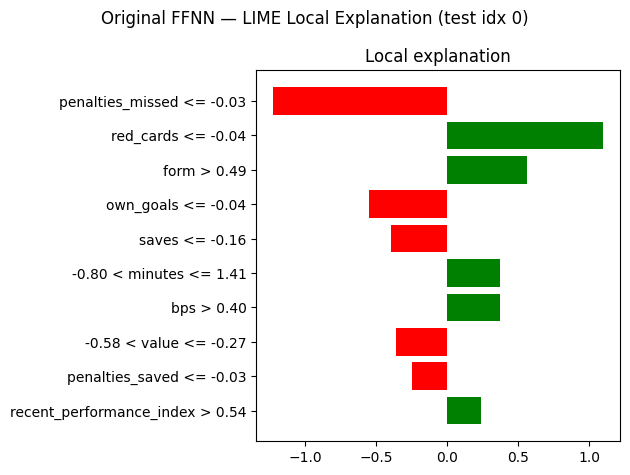


LIME explanation for test index 50 (Original FFNN):
  penalties_missed <= -0.03                           -1.2622
  red_cards <= -0.04                                  +1.1117
  own_goals <= -0.04                                  -0.5962
  form <= -0.73                                       -0.4416
  saves <= -0.16                                      -0.4111
  minutes <= -0.80                                    -0.3514
  penalties_saved <= -0.03                            -0.3197
  bps <= -0.62                                        -0.2808
  recent_performance_index <= -0.66                   -0.2031
  pos_FWD <= -0.39                                    +0.1550


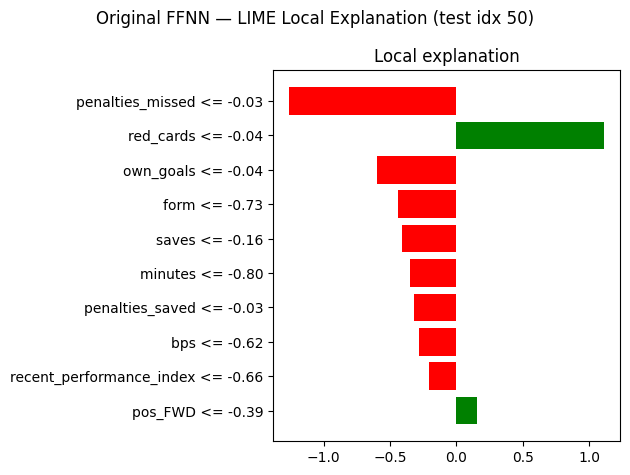


LIME explanation for test index 200 (Original FFNN):
  red_cards <= -0.04                                  +1.2973
  penalties_missed <= -0.03                           -1.2388
  value > 0.29                                        +1.0066
  penalties_saved <= -0.03                            -0.4959
  minutes <= -0.80                                    -0.3493
  saves <= -0.16                                      -0.3241
  bps <= -0.62                                        -0.2934
  recent_performance_index <= -0.66                   -0.1936
  -0.37 < selected <= -0.33                           -0.1776
  -0.73 < form <= -0.46                               -0.1672


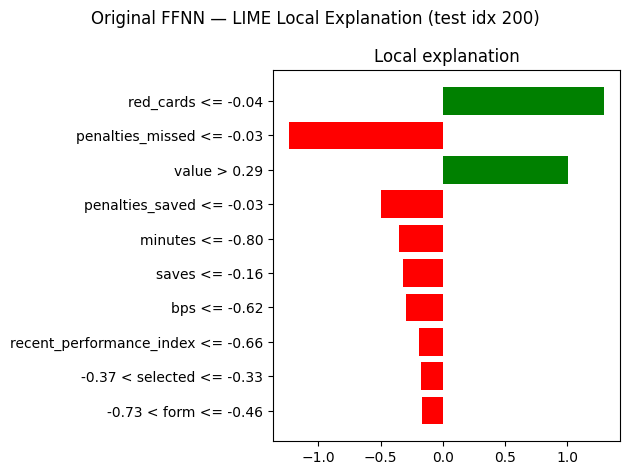

In [62]:
# ================== LIME: LOCAL EXPLANATIONS (Original FFNN) ==================
from lime.lime_tabular import LimeTabularExplainer

lime_exp_ffnn = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=features_final,
    mode='regression',
    discretize_continuous=True,      # easier to read bins
    random_state=42
)

# Pick a few test instances (you can change these indices)
instances = [0, min(50, X_test_scaled.shape[0]-1), min(200, X_test_scaled.shape[0]-1)]

lime_explanations = []
for i in instances:
    exp = lime_exp_ffnn.explain_instance(
        data_row=X_test_scaled[i],
        predict_fn=lambda X: model.predict(X, verbose=0).ravel(),
        num_features=10
    )
    lime_explanations.append(exp)
    # Text summary
    print(f"\nLIME explanation for test index {i} (Original FFNN):")
    for feat, weight in exp.as_list():
        print(f"  {feat:50s}  {weight:+.4f}")
    # Plot
    fig = exp.as_pyplot_figure()
    fig.suptitle(f"Original FFNN — LIME Local Explanation (test idx {i})")
    plt.tight_layout()
    plt.show()

### 🔍 SHAP — Global Explanation (FFNN v2 with Temporal Features)

We compute global SHAP values for **FFNN v2** on **scaled v2 features** (including temporal features: `L1`, `L3m`, `L5_std`):

**What to look for**
- Whether **temporal features** (e.g., `total_points_L1`, `minutes_L3m`, `pts_L5_std`) rise in importance.
- Balance among **raw match stats** (goals, minutes) and **indices** (ICT, form).

**Why this matters**
- Confirms that v2 is leveraging **recent performance history** as intended, not just single-game stats.
- Helps justify the **architectural and feature engineering** choices made for v2.

  0%|          | 0/300 [00:00<?, ?it/s]

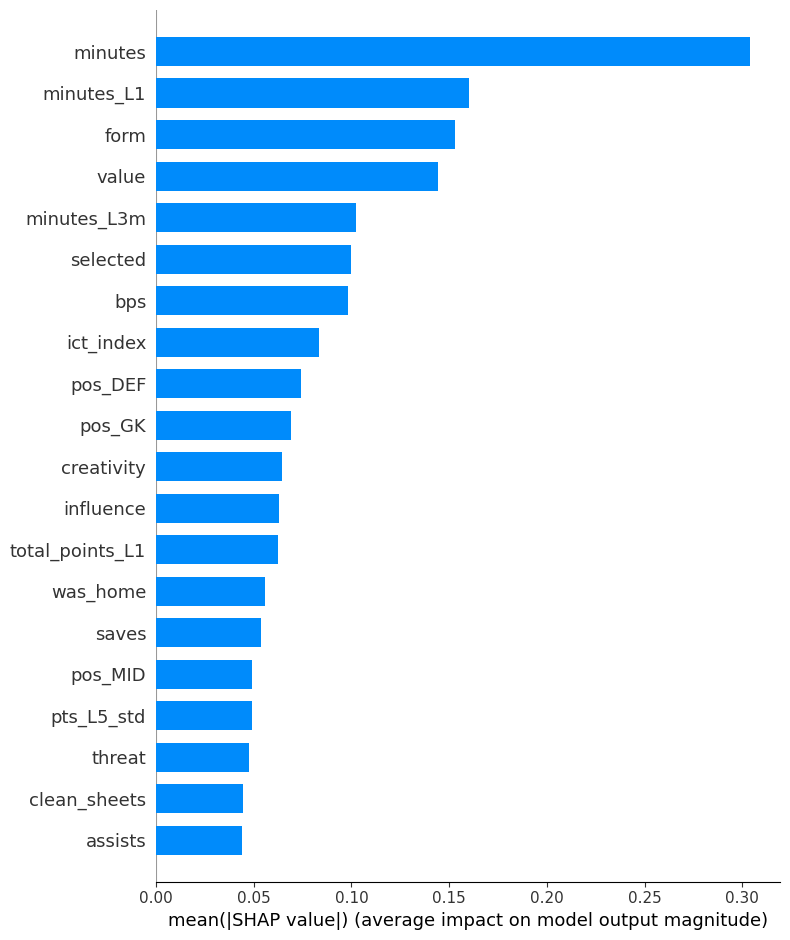

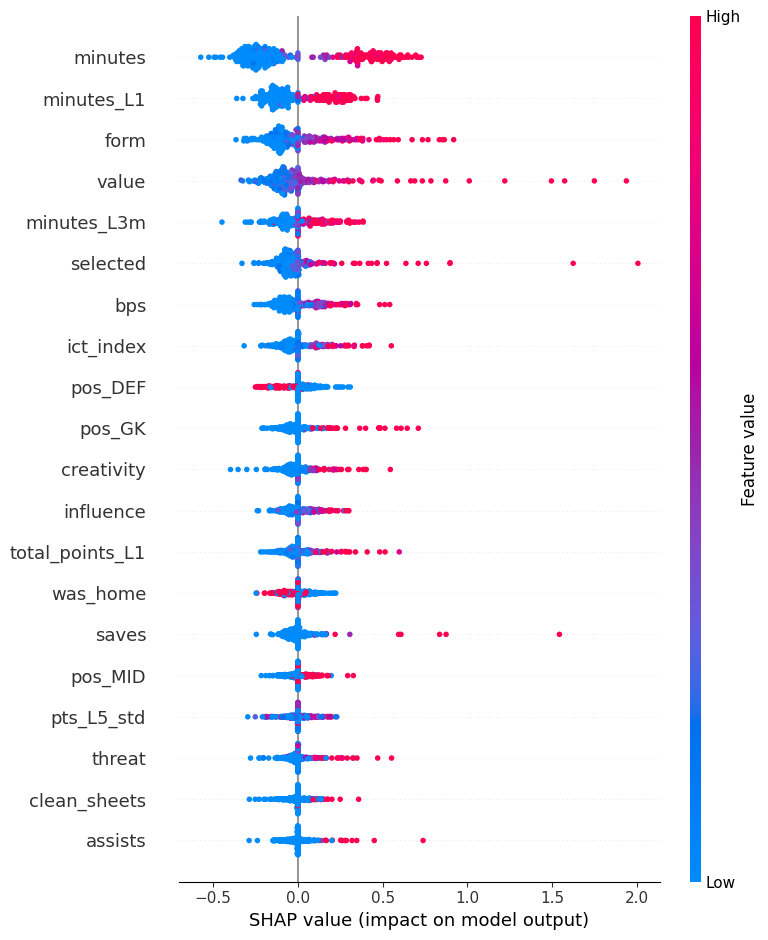

In [63]:
# ================== OPTIMIZED SHAP: GLOBAL EXPLANATION (FFNN v2) ==================
# Summarize background with k-means (K=50 to 100)
background_summary2 = shap.kmeans(X2_train_scaled, 50)

f_pred2 = lambda X: model2.predict(X, verbose=0).ravel()

explainer_ffnn2 = shap.KernelExplainer(f_pred2, background_summary2)

n_explain2 = min(300, X2_test_scaled.shape[0])
shap_vals_ffnn2 = explainer_ffnn2.shap_values(X2_test_scaled[:n_explain2], nsamples=100)

# 1) Global importance (bar)
shap.summary_plot(shap_vals_ffnn2, X2_test_scaled[:n_explain2],
                  feature_names=features2_final, plot_type='bar', show=True)

# 2) Beeswarm
shap.summary_plot(shap_vals_ffnn2, X2_test_scaled[:n_explain2],
                  feature_names=features2_final, show=True)

### 🎯 SHAP — Local Explanation (FFNN v2)

We analyze a **single v2 prediction** (e.g., `i=0`) with Kernel SHAP:

**Expectations**
- Higher `total_points_L1` / `minutes_L3m` should contribute **positively** for consistent starters.
- Higher `pts_L5_std` (volatility) may **reduce** predicted points for risk-heavy profiles (depending on learned relationships).

**Use this to**
- Validate that the **temporal signals** are meaningfully integrated in individual predictions.
- Compare local drivers in v2 vs. v1 to see how temporal context changes the explanation.

In [64]:
# ================== SHAP Local Explanation (FFNN v2) ==================


background_summary2 = shap.kmeans(X2_train_scaled, 50)


f_pred2 = lambda X: model2.predict(X, verbose=0).ravel()


explainer_ffnn2 = shap.KernelExplainer(f_pred2, background_summary2)


i = 0


x_row = X2_test_scaled[i].reshape(1, -1)


shap_vals_single = explainer_ffnn2.shap_values(
    x_row,
    nsamples=100
)


shap.initjs()

shap.force_plot(
    explainer_ffnn2.expected_value,     
    shap_vals_single[0],               
    x_row[0],                           
    feature_names=features2_final
)

  0%|          | 0/1 [00:00<?, ?it/s]

### 🟡 LIME — Local Explanations (FFNN v2 with Temporal Features)

We run LIME on **v2’s scaled feature space** and visualize **top local contributors**:

**Why it’s helpful**
- Converts complex v2 interactions (SELU network + temporal inputs) into a **readable local ranking**.
- Lets you compare **direct engineered features** vs. **indices** (ICT, form) in any single case.

**Consistency check**
- LIME and SHAP should broadly agree on the **most important** features.
- Differences often arise from local sampling vs. global attribution; report both for transparency.


LIME explanation for test index 0 (FFNN v2):
  red_cards <= -0.04                                  +1.7932
  penalties_missed <= -0.03                           -1.5952
  saves <= -0.16                                      -0.9629
  own_goals <= -0.04                                  -0.9331
  pos_GK <= -0.35                                     -0.5298
  penalties_saved <= -0.02                            +0.4398
  form <= -0.77                                       -0.4024
  pos_DEF <= -0.74                                    +0.2751
  selected <= -0.37                                   -0.2549
  minutes <= -0.80                                    -0.2443


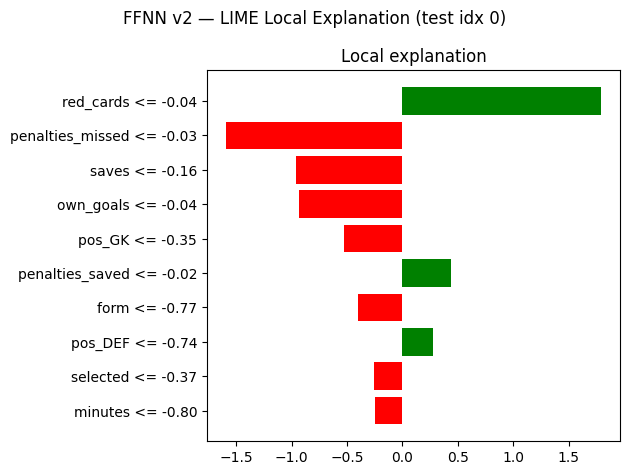


LIME explanation for test index 50 (FFNN v2):
  red_cards <= -0.04                                  +1.4474
  penalties_missed <= -0.03                           -1.0999
  saves <= -0.16                                      -0.9258
  own_goals <= -0.04                                  -0.7470
  pos_GK <= -0.35                                     -0.5802
  form <= -0.77                                       -0.3903
  pos_DEF <= -0.74                                    +0.2729
  clean_sheets <= -0.35                               -0.2665
  bps <= -0.62                                        -0.2481
  minutes <= -0.80                                    -0.2377


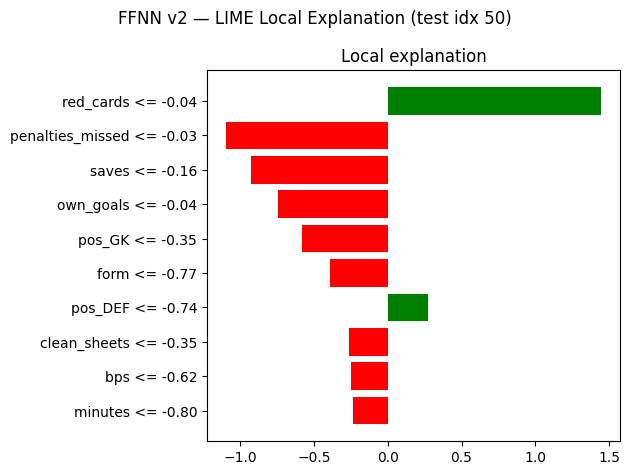


LIME explanation for test index 200 (FFNN v2):
  red_cards <= -0.04                                  +1.5988
  penalties_missed <= -0.03                           -1.4533
  saves <= -0.16                                      -1.0003
  own_goals <= -0.04                                  -0.8630
  pos_GK > -0.35                                      +0.5071
  form <= -0.77                                       -0.4010
  value <= -0.58                                      -0.3931
  bps <= -0.62                                        -0.2640
  clean_sheets <= -0.35                               -0.2401
  selected <= -0.37                                   -0.2320


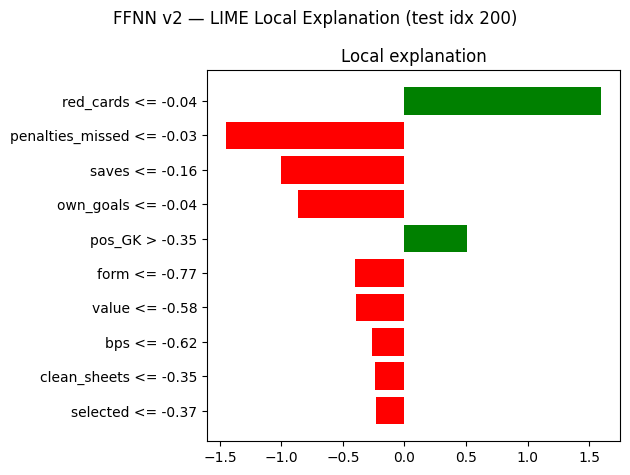

In [65]:
# ================== LIME: LOCAL EXPLANATIONS (FFNN v2) ==================
from lime.lime_tabular import LimeTabularExplainer

lime_exp_ffnn2 = LimeTabularExplainer(
    training_data=X2_train_scaled,
    feature_names=features2_final,
    mode='regression',
    discretize_continuous=True,
    random_state=24
)

instances_v2 = [0, min(50, X2_test_scaled.shape[0]-1), min(200, X2_test_scaled.shape[0]-1)]

lime_explanations_v2 = []
for i in instances_v2:
    exp = lime_exp_ffnn2.explain_instance(
        data_row=X2_test_scaled[i],
        predict_fn=lambda X: model2.predict(X, verbose=0).ravel(),
        num_features=10
    )
    lime_explanations_v2.append(exp)
    print(f"\nLIME explanation for test index {i} (FFNN v2):")
    for feat, weight in exp.as_list():
        print(f"  {feat:50s}  {weight:+.4f}")
    fig = exp.as_pyplot_figure()
    fig.suptitle(f"FFNN v2 — LIME Local Explanation (test idx {i})")
    plt.tight_layout()
    plt.show()

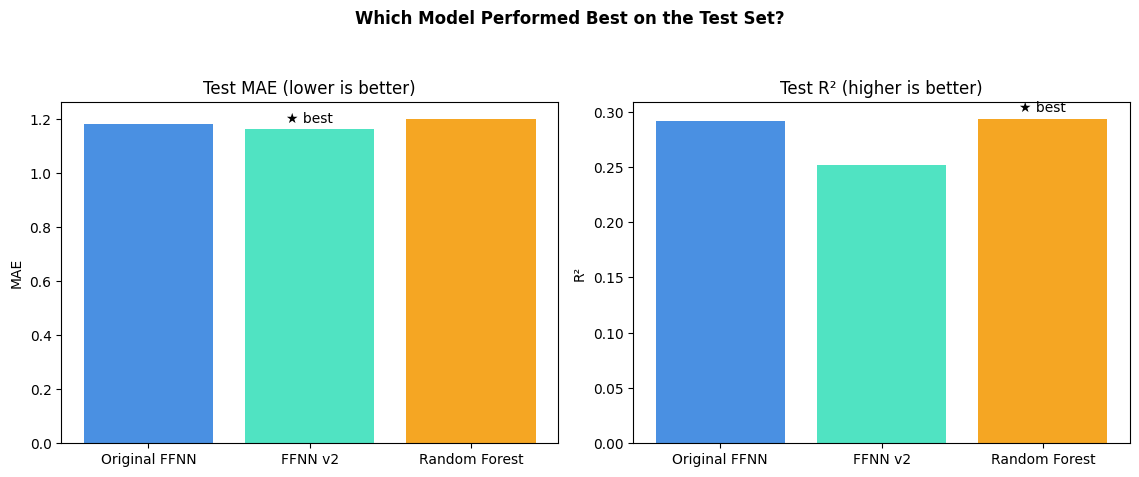

=== Final Verdict (Test set) ===
Best by MAE  : FFNN v2
Best by RMSE : Random Forest
Best by R²   : Random Forest
Overall (rank-sum across MAE & R²): Original FFNN


,Model,MAE,RMSE,R2
0,Original FFNN,1.180,2.140,0.291
1,FFNN v2,1.161,2.203,0.252
2,Random Forest,1.201,2.137,0.294


In [66]:
# ================== FINAL WINNER CHART (Original FFNN vs FFNN v2 vs Random Forest) ==================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build summary table from your TEST metrics dicts ---
summary = pd.DataFrame([
    {"Model": "Original FFNN", "MAE": test_metrics["MAE"],  "RMSE": test_metrics["RMSE"],  "R2": test_metrics["R2"]},
    {"Model": "FFNN v2",       "MAE": test2_metrics["MAE"], "RMSE": test2_metrics["RMSE"], "R2": test2_metrics["R2"]},
    {"Model": "Random Forest", "MAE": rf_test_metrics["MAE"], "RMSE": rf_test_metrics["RMSE"], "R2": rf_test_metrics["R2"]},
])

# --- Winners per metric ---
winner_mae  = summary.loc[summary["MAE"].idxmin(),  "Model"]   # lower is better
winner_rmse = summary.loc[summary["RMSE"].idxmin(), "Model"]   # lower is better
winner_r2   = summary.loc[summary["R2"].idxmax(),   "Model"]   # higher is better

# --- Overall rank (keep same logic as your 2-model code: rank across MAE & R2) ---
rank_df = summary.assign(
    rank_MAE = summary["MAE"].rank(ascending=True,  method="min"),
    rank_R2  = summary["R2"].rank(ascending=False, method="min")
)
rank_df["rank_sum"] = rank_df["rank_MAE"] + rank_df["rank_R2"]
overall_winner = rank_df.loc[rank_df["rank_sum"].idxmin(), "Model"]

# --- Plot: left = Test MAE (lower better), right = Test R² (higher better) ---
fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.5))

palette = ["#4a90e2", "#50e3c2", "#f5a623"]  # Original, v2, RF (blue, teal, amber)

# MAE bar
axes[0].bar(summary["Model"], summary["MAE"], color=palette)
axes[0].set_title("Test MAE (lower is better)")
axes[0].set_ylabel("MAE")
best_idx_mae = summary["MAE"].idxmin()
axes[0].annotate("★ best",
                 xy=(best_idx_mae, summary.loc[best_idx_mae, "MAE"]),
                 xytext=(0, 5), textcoords="offset points", ha="center")

# R2 bar
axes[1].bar(summary["Model"], summary["R2"], color=palette)
axes[1].set_title("Test R² (higher is better)")
axes[1].set_ylabel("R²")
best_idx_r2 = summary["R2"].idxmax()
axes[1].annotate("★ best",
                 xy=(best_idx_r2, summary.loc[best_idx_r2, "R2"]),
                 xytext=(0, 5), textcoords="offset points", ha="center")

plt.suptitle("Which Model Performed Best on the Test Set?", y=1.05, fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# --- Textual verdict ---
print("=== Final Verdict (Test set) ===")
print(f"Best by MAE  : {winner_mae}")
print(f"Best by RMSE : {winner_rmse}")
print(f"Best by R²   : {winner_r2}")
print(f"Overall (rank-sum across MAE & R²): {overall_winner}")

# Styled summary table
display(
    summary.style
        .format({"MAE": "{:.3f}", "RMSE": "{:.3f}", "R2": "{:.3f}"})
        .set_caption("Test-set performance (3 models)")
)